# Introduction

Ce notebook présente une approche pour déterminer le genre d'une musique à travers les caractéristiques fournies par l'API spotify en utilisant des algorithmes de Machine Learning. 

Ce projet s'intègre dans le cadre du cours Python pour la Data Science de l'ENSAE Paris. Il a été mené par Martin Conte, Enzo Moran et Tom Laflotte.

Il suit le plan suivant:

I. Une première approche via l'API Spotify

1. Collecte des données

    a. Constitution d'un premier dataset
    
    b. Collecte du genre des artistes

2. Visualisation

II. Prédiction à l'aide d'une base de données Kaggle 

1. Préparation des données

    a. Gestion des valeurs

    b. Standardisation des variables continues

    c. Imputation des valeur manquantes

    d. Imputation des variables catégorielles *

2. Visualisation des données préparées

    a. Analyse multivariée

    b.Vérification du poids des variables

3. Modélisation

    a. Random Forest

    b. XGBoost

    c. Catboost

Conclusion





# I. Une première approche via l'API Spotify

Tout d'abord nous devons importer toutes les librairies qui nous seront nécessaires pour cette partie

In [83]:
!pip install spotipy
!pip install numpy==1.26.4
!pip install catboost
!pip install scikit-learn==1.5.2

In [84]:
# Librairies générales
import csv
import time
from pprint import pprint

# Librairies scientifiques et de calcul
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

# Librairies pour la manipulation des données
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# Librairies pour l'API Spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Librairies de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    validation_curve,
)
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    recall_score,
    f1_score,
    zero_one_loss,
    classification_report,
)
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostClassifier


## I.1. Collecte des données

Nous avons d'abord essayé de créer une base de données grâce à l'API Spotify.

### I.1.a. Constitution d'un premier dataset

Spotify ne met pas à disposition une quelconque base de donnée déjà constituée. Nous allons donc devoir faire des requêtes successives à l'API pour récolter les informations sur les morceaux choisis, afin de constituer notre premier dataset. Chaque requête permet d'obtenir les metadonnées d'un artiste donné, ou d'une playlist donnée. C'est ce que nous avons choisi de faire.

Pour minimiser le nombre de requêtes, nous sélectionnons une playlist de 10 000 morceaux déjà faite par un utilisateur Spotify, afin d'obtenir des informations sur chaque morceau qui la compose : titre, id, artist, artist_id. Ensuite, nous récupérons les informations qui nous intéressent sur chaque morceau : les track features, qui sont un tas d'indices quantitatifs. Enfin, nous récupérons le genre qui n'est associé qu'à l'artiste, et pas au morceau. C'est ici une limite préoccupante : le genre qui est la variable à prédire n'est en fait que le genre de l'artiste et pas le genre véritable du morceau.

D'abord, on initialise le client Spotify pour l'obtention des données via l'API grâce au token d'accès.

In [85]:
def spotify_client():
    """
    Initilise le client de l'API Spotify 
    Retourne un client Spotify authentifié
    """
    return spotipy.Spotify(auth_manager=SpotifyClientCredentials(
        client_id="d666ee3ae4c94b85945c3dba39776f4f",
        client_secret="c1973a77acbe48c0b2f105e4f57d7d46" 
    ))

Ensuite, nous utilisons ce client pour notre requête sur la playlist de 10 000 morceaux.

Nous entrons l'id de la playlist en question. Nous récupérons les informations de la playlist relatives aux morceaux dans `get_all_playlist_tracks`. Avec les informations obtenues précédemment, nous créons avec `get_track_id_and_artist` un dataframe qui pour chaque morceau de la playlist en donne le titre, l'id, l'artist, l'artist id.

Notre objectif final est d'obtenir un fichier csv compilant toutes les données fournies par l'API de Spotify dans un fichier csv.
Voici la fonction réalisant cette tache :

In [86]:
def get_playlists_data_to_csv(playlist_ids):
    """Cette fonction permet de récupérer les données de différentes playlists dans un fichier CSV.
    Paramètres :
        - playlist_ids : une liste de playlists dont nous voulons récupérer les données
    """

    names=[]
    track_data=[]
    file_name=''
    for playlist in playlist_ids: 
        print(f"Fetching playlist {playlist} tracks...")
        tracks = fetch_playlist_tracks(playlist)
        print("Fetching track data...")
        track_data+=(fetch_track_data(tracks))
    for id in playlist_ids:
        names.append(spotify_client().playlist(id)['name'])
    for name in names:
        file_name+=name+'+'
    file_name=file_name[:-1]
    print(file_name)
    if track_data:
        save_to_csv(track_data, f"playlists_{file_name}_data.csv")
    else:
        print("No data to save.")

Détaillons cette fonction, la fonction `fetch_playlist_tracks` est définie ci-dessous permet l'obtention d'informations identifiant l'ensemble des musiques d'une playlist.

In [87]:
def fetch_playlist_tracks(playlist_id):
    """
    Récupère toutes les pistes d'une playlist Spotify. 
    Paramètres :
        - playlist_id : ID de la playlist Spotify.
    Renvoie une liste de dictionnaires contenant les détails des pistes.
    """

    tracks = []
    results = spotify_client().playlist_tracks(playlist_id)
    while results:
        for item in results['items']:
            track = item['track']
            if track:  # Ensure the track is not None
                tracks.append(track)
        results = spotify_client().next(results) if results['next'] else None
    return tracks

Il faut également obtenir le genre de l'artiste que nous assimilerons dans un premier temps à celui de la musique. Ici, nous ne sélectionnons que le genre principal de l'artiste pour plus de simplicité

In [88]:
def fetch_artist_genre(track):
    """
    Cette fonction récupère le genre d'un artiste avec une piste de cet artiste. Ce genre sera 
    considéré plus tard comme le genre de la chanson.

    Paramètres :
        - track : un dictionnaire contenant des informations sur la piste.

    Retourne :
        - genre : une chaîne de caractères représentant le genre de l'artiste.
    """

    artist=track['artists'][0]['id']
    if spotify_client().artist(artist)['genres'] != []:
        return spotify_client().artist(artist)['genres'][0]
    else:
        return 'N/A'

On peut alors obtenir l'ensemble des informations relatives à chaque musique utiles à l'analyse (dansabilité, tempo...) via la fonction `fetch_track_data`. Du fait des restrictions de requêtes imposées par l'API de spotify, nous avons mis en place des requêtes par paquets de 100 chansons suivi d'une pause d'une minute, cette approche nous a permis de constituer une première base de données de 1500 musiques, en répétant ce procédé sur une plus longue période, il serait possible d'obtenir les données de l'ensemble de la playlist mais comme nous le détaillerons plus tard, nous n'avons pas retenu cette approche et nous contenterons de la base de données intermédiaire.

In [89]:
def fetch_track_data(tracks):
    """
    Récupère les métadonnées et les caractéristiques audio de chaque piste dans la playlist.
    Paramètres :
        - tracks : liste des pistes de la playlist.
    Retourne une liste de dictionnaires contenant les métadonnées et les caractéristiques audio des pistes.
    """

    track_data = []
    i=0
    j=0
    for track in tracks:
        track_id = track['id']
        i+=1
        print(i)
        audio_features = spotify_client().audio_features([track_id])[0]
        genre=fetch_artist_genre(track)
        if audio_features: 
            artist_name = ", ".join([artist['name'] for artist in track['artists']])
            dict_track={"track Name": track['name'],
                "artists": artist_name,
                "track_id": track_id,
                "popularity": track['popularity'],
                "duration_ms": track['duration_ms'],
                "explicit": track['explicit'], 'genre': genre}
            for key in audio_features.keys():
                dict_track[key]=audio_features[key]
            track_data.append(dict_track)
        if i==100:
            j+=1
            save_to_csv(track_data, f"intermédiaire{j}")
            i=0
            time.sleep(60)
    return track_data


Il ne reste plus qu'à sauvegarder le tout au format csv: 

In [90]:
def save_to_csv(data, filename):
    """
    Enregistre la liste des données des pistes dans un fichier CSV.
    Paramètres :
    - data : liste de dictionnaires contenant les détails des pistes.
    - filename : nom du fichier CSV de sortie.
    """

    keys = data[0].keys() if data else []
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=keys)
        writer.writeheader()
        writer.writerows(data)
    print(f"Data saved to {filename}")


La requête suivante permet de constituer un premier dataset consitué des musiques de la playlist "Top 10 000 songs of All-Time":

In [91]:
# get_playlists_data_to_csv(['1G8IpkZKobrIlXcVPoSIuf'])

### I.1.b. Collecte du genre de la playlist

Nous avons réussi à enregistrer une première version de notre df que nous visualiserons en partie I. 2. Cependant, cette approche ne nous donne que le genre de l'artiste et pas nécessairement de la playlist. C'est pourquoi nous avons décidé d'adapter certaines de nos fonctions afin de collecter le genre des playlists et de collecter les données de playlists aux genres spécifiques. Le genre de la playlist sera ensuite assimilé à celui de l'artiste. A cet effet, nous avons ajouté la fonction `get_playlist_data_to_csv_with_genre`

In [92]:
def get_playlists_data_to_csv_with_genre(playlist_ids):
    """
    Cette fonction permet de récupérer les données de différentes playlists dans un fichier CSV.
    Paramètres :
        - playlist_ids : un dictionnaire dont les clés sont des genres et les valeurs des playlists (chaînes de caractères).
    """

    names=[]
    track_data=[]
    file_name=''
    for key in playlist_ids.keys(): 
        print(f"Fetching playlist {playlist_ids[key]} tracks...")
        tracks = fetch_playlist_tracks(playlist_ids[key])
        print("Fetching track data...")
        track_data+=(fetch_track_data_without_genre(tracks, key))
    for key1 in playlist_ids.keys():
        names.append(spotify_client().playlist(playlist_ids[key1])['name'])
    for name in names:
        file_name+=name+'+'
    file_name=file_name[:-1]
    print(file_name)
    if track_data:
        save_to_csv(track_data, f"playlists_{file_name}_data.csv")

Détaillons les fonctions appelées par cette fonction. `fetch_track_data_without_genre` permet d'obtenir les données d'une liste de chansons dont le genre est déjà connu

In [93]:
def fetch_track_data_without_genre(tracks,genre):
    """
    Récupère les métadonnées et les caractéristiques audio de chaque piste dans la playlist en connaissant le genre de la playlist.
    Paramètres :
        - tracks : liste des pistes de la playlist.
    Retourne une liste de dictionnaires contenant les métadonnées et les caractéristiques audio des pistes.
    """

    track_data = []
    i=0
    for track in tracks:
        track_id = track['id']
        i+=1
        audio_features = spotify_client().audio_features([track_id])[0]
        if audio_features:  # Ensure audio features are available
            artist_name = ", ".join([artist['name'] for artist in track['artists']])
            dict_track={"track Name": track['name'],
                "artists": artist_name,
                "track_id": track_id,
                "popularity": track['popularity'],
                "duration_ms": track['duration_ms'],
                "explicit": track['explicit'], 'genre': genre}
            for key in audio_features.keys():
                dict_track[key]=audio_features[key]
            track_data.append(dict_track)
        if i==100:
            j+=1
            save_to_csv(track_data, f"intermédiaire_realdb{j}")
            i=0
            time.sleep(60)
    return track_data

Le genre est déjà connu car il s'agit de la clé utilisée lors des requêtes faites à la fonction `get_playlist_data_to_csv_with_genre`. Voici un exemple de requête:

In [94]:
"""
get_playlists_data_to_csv_with_genre({'rap' : '4KsrGBWG6gzBwGe9dx16OE', 
                                      'country' : '33mU9g6y8nKFAOyiISor0G',
                                      'blues' : '7BDUphylF8dfPKFo9Tvdr9',
                                      'metal' : '1yYEy4MtNLVScj74wcPR7w',
                                      'r_and_b' : '7CI3NR7rvCkgiLhch1qprf',
                                      'classical_music' : '5n9btvMZ52rxwozhQdKU7v',
                                      'jazz' : '79Bcltku1dcD08JcAM29kL',
                                      'pop' : '7gqtGYFoCR3tAqTtEUQZTw'})
"""

"\nget_playlists_data_to_csv_with_genre({'rap' : '4KsrGBWG6gzBwGe9dx16OE', \n                                      'country' : '33mU9g6y8nKFAOyiISor0G',\n                                      'blues' : '7BDUphylF8dfPKFo9Tvdr9',\n                                      'metal' : '1yYEy4MtNLVScj74wcPR7w',\n                                      'r_and_b' : '7CI3NR7rvCkgiLhch1qprf',\n                                      'classical_music' : '5n9btvMZ52rxwozhQdKU7v',\n                                      'jazz' : '79Bcltku1dcD08JcAM29kL',\n                                      'pop' : '7gqtGYFoCR3tAqTtEUQZTw'})\n"

Cette deuxième approche nous aurait permis de constituer un dataset plus précis mais nous n'avons pas pu la mettre en place. En effet, les conditions d'utilisation de l'API spotify ont été changées et il n'est plus possible de faire des requêtes donnant accès aux métadonnées des chansons. Notre Machine Learning utilisera donc un dataset Kaggle. Néanmoins, nous pouvons visualiser les données collectées en partie I.1.a

## I.2. Visualisation

Nous utilisons dans cette première partie la base de données constituée avec la méthode de la partie I.1 que nous avons stocké sur SSPCloud.

In [95]:
file_path = "/ponte/Projet_data/first_db.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

In [96]:
df.head()

,track Name,artists,track_id,popularity,duration_ms,explicit,genre,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,time_signature
0,Like a Rolling Stone,Bob Dylan,3AhXZa8sUQht0UEdBJgpGc,69,369600,False,classic rock,0.482,0.721,0,...,0.000000,0.1890,0.557,95.263,audio_features,3AhXZa8sUQht0UEdBJgpGc,spotify:track:3AhXZa8sUQht0UEdBJgpGc,https://api.spotify.com/v1/tracks/3AhXZa8sUQht...,https://api.spotify.com/v1/audio-analysis/3AhX...,4
1,Smells Like Teen Spirit,Nirvana,3oTlkzk1OtrhH8wBAduVEi,0,300977,False,grunge,0.485,0.863,1,...,0.016200,0.1380,0.767,116.835,audio_features,3oTlkzk1OtrhH8wBAduVEi,spotify:track:3oTlkzk1OtrhH8wBAduVEi,https://api.spotify.com/v1/tracks/3oTlkzk1Otrh...,https://api.spotify.com/v1/audio-analysis/3oTl...,4
2,A Day In The Life - Remastered,The Beatles,3ZFBeIyP41HhnALjxWy1pR,0,337413,False,british invasion,0.364,0.457,4,...,0.000106,0.9220,0.175,163.219,audio_features,3ZFBeIyP41HhnALjxWy1pR,spotify:track:3ZFBeIyP41HhnALjxWy1pR,https://api.spotify.com/v1/tracks/3ZFBeIyP41Hh...,https://api.spotify.com/v1/audio-analysis/3ZFB...,4
3,Good Vibrations (Mono),The Beach Boys,5Qt4Cc66g24QWwGP3YYV9y,17,219147,False,baroque pop,0.398,0.413,1,...,0.000025,0.0891,0.331,133.574,audio_features,5Qt4Cc66g24QWwGP3YYV9y,spotify:track:5Qt4Cc66g24QWwGP3YYV9y,https://api.spotify.com/v1/tracks/5Qt4Cc66g24Q...,https://api.spotify.com/v1/audio-analysis/5Qt4...,4
4,Johnny B Goode,Chuck Berry,7MH2ZclofPlTrZOkPzZKhK,0,160893,False,blues,0.518,0.756,10,...,0.000062,0.3170,0.968,166.429,audio_features,7MH2ZclofPlTrZOkPzZKhK,spotify:track:7MH2ZclofPlTrZOkPzZKhK,https://api.spotify.com/v1/tracks/7MH2ZclofPlT...,https://api.spotify.com/v1/audio-analysis/7MH2...,4


### I.2.a. Pré-Nettoyage

On supprime les colonnes de la database servant uniquement à identifier les musiques :


In [97]:
df = df.drop(['track Name','track_id','type','id','uri','track_href', 'analysis_url'], axis=1)

Il semblerait qu'il y ait de nombreux genres musicaux qui en réalité pourraient être considérés comme des sous-genres, nous allons donc les regrouper.

In [98]:
genres = df['genre'].unique().tolist()
print(genres)

['classic rock', 'grunge', 'british invasion', 'baroque pop', 'blues', 'classic soul', 'brill building pop', 'album rock', 'r&b', 'rock-and-roll', 'heartland rock', 'alternative rock', 'atl hip hop', 'escape room', 'bronx hip hop', 'adult standards', 'art rock', 'funk', 'motown', 'pop', 'acid rock', 'classic garage rock', 'dance pop', 'disco', 'madchester', 'britpop', 'downtempo', 'conscious hip hop', 'east coast hip hop', 'alternative dance', 'classic girl group', 'art pop', 'lilith', 'glam metal', 'blues rock', 'chicago rap', 'electro', 'beatlesque', 'piano rock', 'irish rock', 'europop', 'lgbtq+ hip hop', 'british soul', 'reggae', 'french shoegaze', 'country', 'big beat', 'barbadian pop', 'mellow gold', 'candy pop', 'canadian hip hop', 'classic soundtrack', 'american folk revival', 'garage rock', 'australian psych', 'afrofuturism', 'g funk', 'new romantic', 'australian dance', 'brooklyn indie', 'dusseldorf electronic', 'arkansas country', 'irish punk', 'louisiana blues', 'acoustic b

In [99]:
categories = {
    "rap": [
        'hip hop', 'rap', 'dirty south rap', 'melodic rap', 'conscious hip hop', 'alternative hip hop', 'chicago rap', 
        'bronx hip hop', 'detroit hip hop', 'gangster rap', 'canadian hip hop', 'atl hip hop', 'lgbtq+ hip hop', 'bboy', 'hip pop'
    ],
    "rock": [
        'classic rock', 'album rock', 'alternative rock', 'dance rock', 'hard rock', 'soft rock', 'irish rock', 'piano rock', 
        'australian rock', 'detroit rock', 'british blues', 'garage rock', 'classic garage rock', 'glam rock', 'art rock', 
        'alternative metal', 'folk rock', 'country rock', 'protopunk', 'space rock', 'experimental rock', 'modern rock', 
        'surf music', 'pub rock', 'new wave', 'dance-punk'
    ],
    "pop": [
        'pop', 'dance pop', 'pop rock', 'ambient pop', 'alternative pop', 'bedroom pop', 'canadian pop', 'british soul', 
        'classic country pop', 'barbadian pop', 'bubblegum pop', 'torch song', 'french shoegaze', 'new wave pop', 
        'brill building pop', 'beatlesque', 'britpop', 'art pop', 'candy pop','power pop','electropop', 'experimental pop'
    ],
    "blues": [
        'blues', 'blues rock', 'classic soul', 'r&b', 'british blues', 
        'louisiana blues', 'acoustic blues'
    ],
    "jazz":['cool jazz', 'bebop', 
        'avant-garde jazz', 'big band', 'hot jazz', 'jazz blues', 'gospel', 'soul jazz'],
    "country": [
        'folk', 'american folk revival', 'appalachian folk', 'ambient folk', 'bluegrass', 'bluegrass gospel', 'celtic punk', 
        'country', 'country rock', 'bakersfield sound', 'arkansas country', 'cowboy western', 'alternative americana'
    ],
    "electro": [
        'edm', 'house', 'acid house', 'ambient', 'ambient house', 'ambient pop', 'dance-punk', 'electro', 'indietronica', 
        'balearic', 'atmospheric dnb', 'filter house', 'hi-nrg', 'big beat'
    ],
    "classical": [
        'african-american classical', 'baroque pop', 'torch song', 'classic soundtrack', 'adult standards'
    ]
}


In [100]:
def assign_category(genre):
    for category, keywords in categories.items():
        if genre in keywords:
            return category
        elif genre=='N/A':
            return 
    return "other"

df["category"] = df["genre"].apply(assign_category)

### I.2.b Visualisation des données

Analysons tout d'abord les variables catégoriques de notre dataset :

In [101]:
categorical_var = df.copy().select_dtypes(include=["object"]).columns.to_list()
categorical_var.extend(["key","mode","time_signature","explicit"])

In [102]:
df[categorical_var].nunique()

artists           822
genre             198
category            9
key                12
mode                2
time_signature      4
explicit            2
dtype: int64

Pour les variables avec un faible nombre de valeurs différentes, nous allons les représenter sous forme d'histogramme.

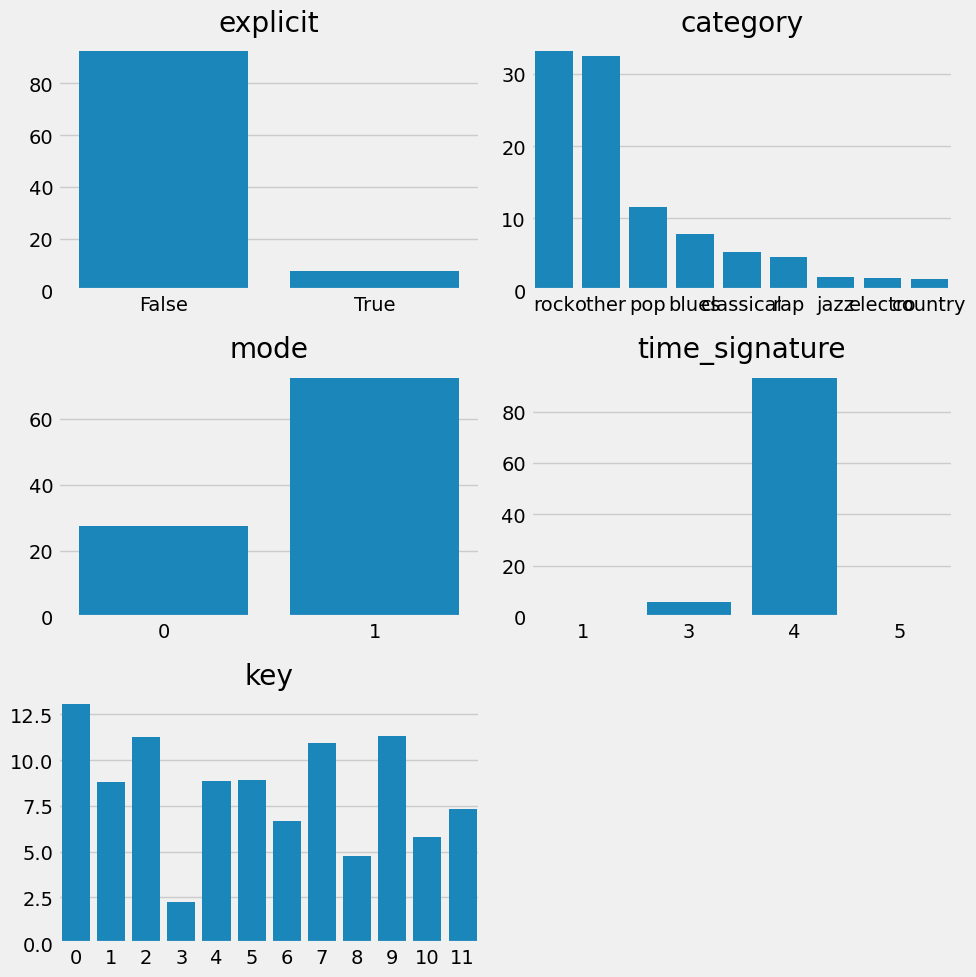

In [103]:
df_barplot = df[["explicit","category","mode","time_signature","key"]].copy()
plt.figure(figsize=(10,10))

for c,var in enumerate(df_barplot.columns):
  # calcul de la fréquence de chaque variable
  df_plot= df_barplot[var].value_counts(normalize=True).to_frame("frequency").reset_index(names=var)
  df_plot["frequency"] = df_plot["frequency"]*100

  # affichage de l'histogramme
  plt.subplot(3,2,c+1)
  sns.barplot(data=df_plot, x=var, y="frequency")
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

Nous observons que la catégorie qui est le regroupement du genre est très mal répartie, cela risque de poser problème pour notre modèle car il s'agit de la variable cible qui devrait donc être répartie de façon uniforme afin de ne pas créer de biais dans notre modèle.

Pour les colonnes `artists` et `genre` nous allons visualiser le top10 des artistes les plus représentés

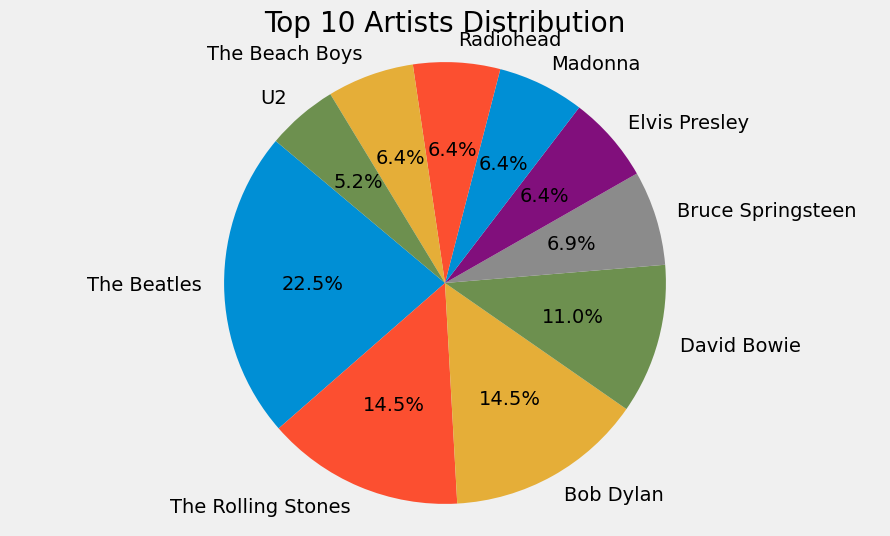

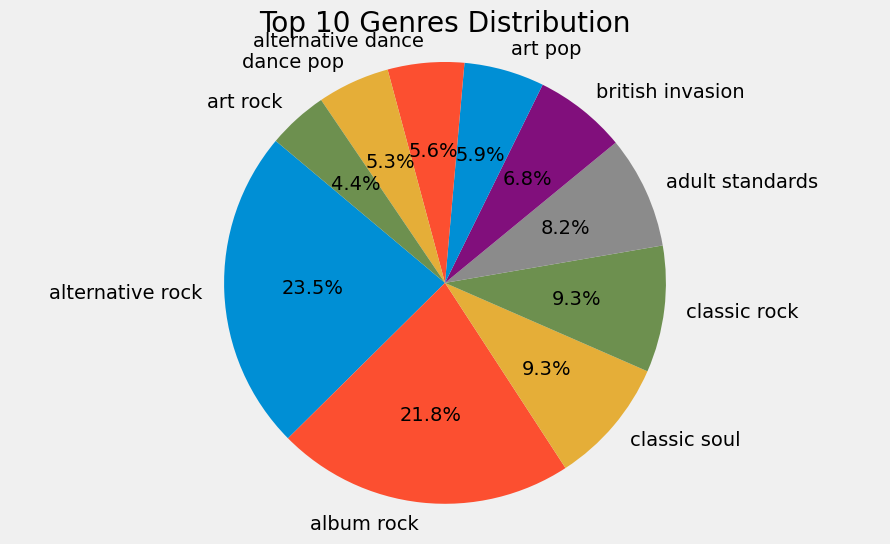

In [104]:
# Diagramme circulaire pour artist
artist_counts = df['artists'].value_counts().head(10) 
plt.figure(figsize=(10, 6))
plt.pie(artist_counts, labels=artist_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Artists Distribution')
plt.axis('equal')  
plt.show()

# Diagramme circulaire pour genre
genre_counts = df['genre'].value_counts().head(10)  
plt.figure(figsize=(10, 6))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Genres Distribution')
plt.axis('equal')  
plt.show()

De même, la répartition des genres dans notre dataset n'est pas adaptée à notre problématique. Nous avons donc tenté l'approche détaillée en partie I.1.b. qui s'est avérée infructueuse du fait d'un [changement de la politique de Spotify](https://developer.spotify.com/blog/2024-11-27-changes-to-the-web-api).

Nous allons donc, pour la suite utiliser un [dataset issu de Kaggle](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs) de 30 000 musiques qui a été construit quelques années auparavant en utilisant les mêmes méthodes que nous avons pu mettre en place pour construire notre dataset incomplet.

# II. Prédiction à l'aide d'une base de données Kaggle

Comme l'API Spotify a bloqué l'accès aux caractéristiques de toutes ses musiques à compter de la fin de ce mois de novembre 2024 *(en effet tous les paramètres tels que danceabilty, liveness, tempo... se sont soudainement retrouvés inaccessibles)*, nous n'avons pas pu finaliser notre propre base de données à temps. Ainsi, le choix a été fait de continuer à travailler avec une base de donnés Kaggle pour notre projet. Ce dataset possède 30 000 lignes et indique les caractéristiques des musiques qui nous intéressent ainsi que leur genre grâce à la playlist d'où ils proviennent.

Nous nous occuperons dans un premier temps de nettoyer les données et de les mettre en forme, avant de visualiser les variables et tester leur pertinence dans notre modèle. Enfin, nous essaierons à partir de ce qui a été fait de mettre en place un modèle permettant de prédire le genre d'une musique grâce à ses caractéristiques.

## II.1. Préparation des données

Dans cette partie nous allons nous occuper du *preprocessing* c'est à dire du nettoyage et de la mise en forme des données en vue de la création du modèle

In [105]:
file_path = "/tlaflotte/genre_detector/spotify_tracks.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

On commence par éliminer toutes les colonnes qui contiennent des noms et des identifiants puisqu'elles n'apportent aucune information pertinente pour notre étude. Nous choisissons aussi de supprimer la colonne `popularity` car celle-ci est calculée de façon très obscure et comporte de trop nombreuses valeurs nulles pour les imputer alors même que les chansons sont célèbres.

In [106]:
df.drop(columns=["track_name","track_id","track_artist","track_album_id","track_album_name","track_album_release_date",
       "playlist_name", "playlist_id","track_popularity"], inplace = True)

In [107]:
df.columns

Index(['playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms'],
      dtype='object')

### II.1.a Gestion des valeurs aberrantes 

Nous commencerons par traiter les valeurs aberrantes (outliers). Pour ce faire, nous utiliserons la méthode du Z-score, en considérant comme outliers les valeurs ayant un Z-score supérieur à 3 en valeur absolue. Cette approche est justifiée par le fait que la majorité des variables ont des distributions proches d'une distribution normale (cf. ci-dessous), bien que certaines d'entre elles, telles que le `tempo`, la `valence` et la popularité du morceau `track_popularity`, présentent des exceptions.


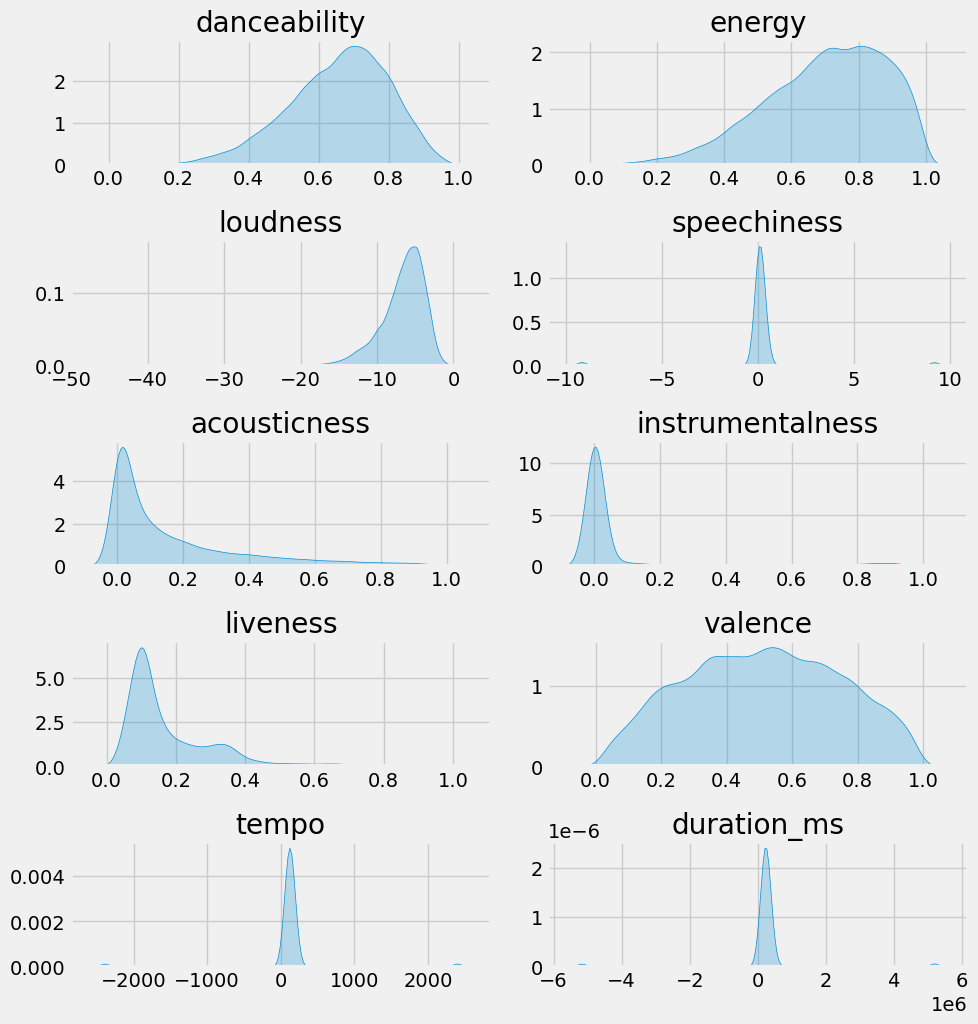

In [108]:
continuous_var = [
       'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']
plt.figure(figsize=(10,12))

for c,var in enumerate(continuous_var):
  plt.subplot(6,2,c+1)
  sns.kdeplot(data=df[continuous_var], x=var, fill=var)
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

La fonction `count_outliers_zscore`, utilisée ci-dessous, nous permet de calculer les outliers par rapport à un seuil, fixé à 3 par défaut.

In [109]:
def count_outliers_zscore(df, threshold=3):
    """
    Compte le nombre d'outliers dans chaque colonne continue d'un DataFrame selon la méthode Z-Score.

    Parameters:
    - df (pd.DataFrame): Le DataFrame contenant les colonnes continues.
    - threshold (float): Seuil pour considérer une valeur comme outlier (par défaut : 3).

    Returns:
    - pd.Series: Série avec le nombre d'outliers pour chaque colonne.
    """
    outlier_counts = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):  # Vérifie que la colonne est numérique
            z_scores = zscore(df[column])
            outliers = np.abs(z_scores) > threshold
            outlier_counts[column] = np.sum(outliers)

    return pd.Series(outlier_counts)

outliers_zscore = count_outliers_zscore(df)

count_outliers_zscore(df)


danceability         123
energy               166
key                    0
loudness             368
mode                   0
speechiness         1641
acousticness         657
instrumentalness    1692
liveness               0
valence                0
tempo               1641
duration_ms         1641
dtype: int64

On identifie un petit nombre d'outliers et rien n'indique que ces valeurs soient incorrectes ou aberrantes, mais simplement qu'elles s'écartent légèrement des valeurs habituelles. Ainsi plutôt que de supprimer les lignes en question, on va plutôt winsorizer les valeurs.

La fonction `winsorize_outliers` permet justement d'effectuer cette opération, on va appliquer cette fonction à toutes les colonnes continues, toujours avec un seuil de 3.

In [110]:
def winsorize_outliers(df, columns, threshold=3):
    """
    Winsorise les valeurs aberrantes (outliers) dans les colonnes continues d'un DataFrame,
    sans modifier le DataFrame original.

    Parameters:
    - df (pd.DataFrame): DataFrame contenant les colonnes continues.
    - columns (list): Liste des colonnes à traiter.
    - threshold (float): Seuil z-score pour définir les outliers.

    Returns:
    - pd.DataFrame: Nouveau DataFrame avec les colonnes ajustées.
    """
    # Création d'une copie du DataFrame pour ne pas modifier l'original
    df_copy = df.copy()

    for column in columns:
        z_scores = zscore(df_copy[column])
        
        # Calcul des limites
        lower_bound = df_copy[column][z_scores > -threshold].min()
        upper_bound = df_copy[column][z_scores < threshold].max()
        
        # Winsorisation
        df_copy[column] = np.clip(df_copy[column], lower_bound, upper_bound)
        
    return df_copy

df_winsorized = winsorize_outliers(df, ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'tempo','duration_ms'], 3)

In [111]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,31028.000000,31849.000000,32833.000000,3.283300e+04
mean,0.654850,0.698619,5.374471,-6.719499,0.565711,0.093718,0.175334,0.084747,0.189994,0.510953,115.492037,2.223588e+05
std,0.145085,0.180910,3.611657,2.988436,0.495671,2.055226,0.219633,0.224230,0.154279,0.232926,536.453234,1.158704e+06
min,0.000000,0.000175,0.000000,-46.448000,0.000000,-9.180000,0.000000,0.000000,0.009360,0.000000,-2394.400000,-5.178100e+06
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.040200,0.015100,0.000000,0.092700,0.331000,98.231000,1.863330e+05
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062600,0.080400,0.000016,0.127000,0.512000,121.985000,2.162560e+05
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.139000,0.255000,0.004830,0.248000,0.693000,135.290000,2.567570e+05
max,0.983000,1.000000,11.000000,1.275000,1.000000,9.180000,0.994000,0.994000,0.996000,0.991000,2394.400000,5.178100e+06


In [112]:
df_winsorized.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,31028.000000,31849.000000,32833.000000,32833.000000
mean,0.654991,0.698879,5.374471,-6.689571,0.565711,0.124361,0.174019,0.079160,0.189994,0.510953,120.370004,228054.461700
std,0.144626,0.180072,3.611657,2.860485,0.495671,0.160875,0.215375,0.204893,0.154279,0.232926,36.023518,82372.437855
min,0.220000,0.156000,0.000000,-15.682000,0.000000,0.000000,0.000000,0.000000,0.009360,0.000000,0.000000,4000.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.040200,0.015100,0.000000,0.092700,0.331000,98.231000,186333.000000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062600,0.080400,0.000016,0.127000,0.512000,121.985000,216256.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.139000,0.255000,0.004830,0.248000,0.693000,135.290000,256757.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.833000,0.757000,0.996000,0.991000,220.252000,517810.000000


On remarque ainsi que certaines valeurs extrêmes ont été modifiées, sans que les statistiques les plus basiques (moyenne, variance, médiane et quartiles) ne soient significativement impactées. On peut donc remplacer notre tableau par ce nouveau tableau winsorisé.

In [113]:
df = df_winsorized

### II.1.b Standardisation des variables continues 

Ensuite, pour continuer à préparer le dataset et garantir que notre modèle de prédiction du genre fonctionne bien, il est important de standardiser les variables continues.

In [114]:
columns_to_standardize = ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration_ms']

scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[columns_to_standardize] = scaler.fit_transform(df_standardized[columns_to_standardize])

Vérifions maintenant que les colonnes de `df_standardized` ont bien été standardisées avant de remplacer le tableau original `df` par ce nouveau.

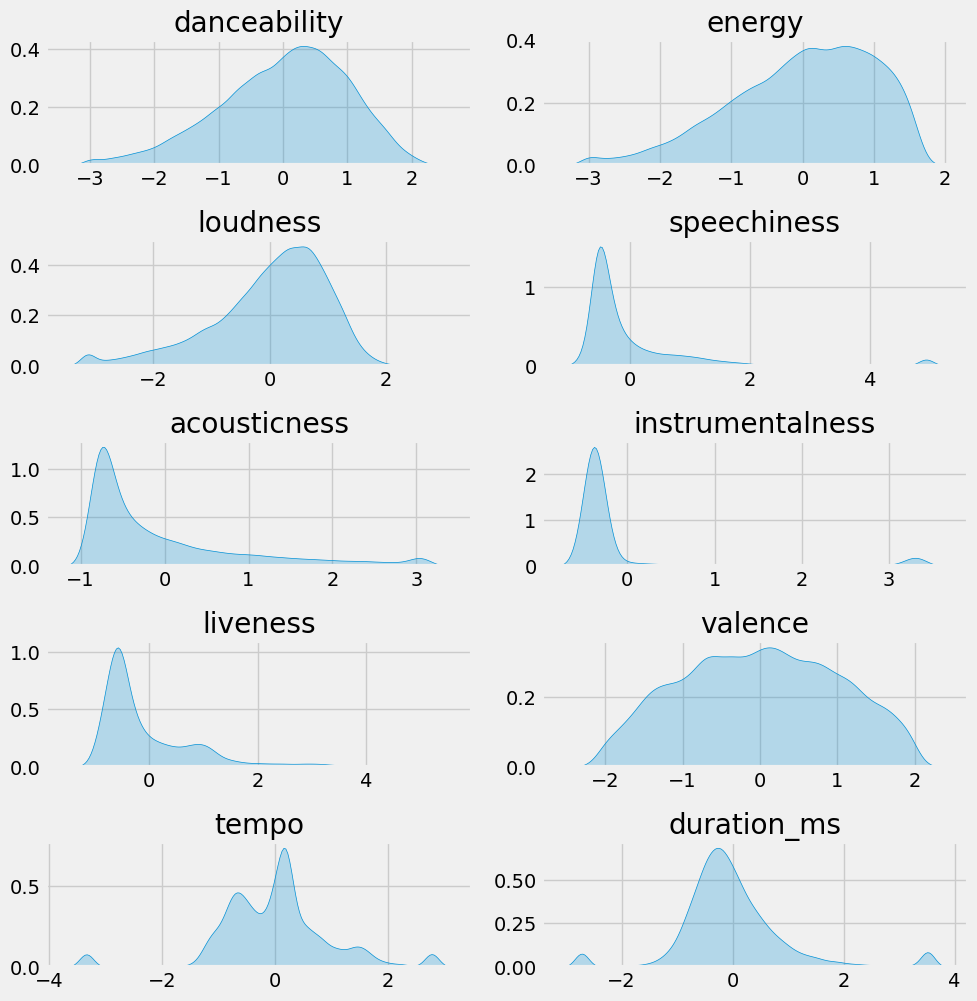

In [115]:
plt.figure(figsize=(10,12))

for c,var in enumerate(continuous_var):
  plt.subplot(6,2,c+1)
  sns.kdeplot(data=df_standardized[continuous_var], x=var, fill=var)
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")
    
plt.tight_layout()

In [116]:
# Calcul de la moyenne et de la variance des colonnes standardisées
for col in columns_to_standardize:
    mean = df_standardized[col].mean()
    variance = df_standardized[col].var()
    print(f"Variable : {col}")
    print(f"Moyenne : {mean:.6f}")
    print(f"Variance : {variance:.6f}\n")

Variable : danceability
Moyenne : 0.000000
Variance : 1.000030

Variable : energy
Moyenne : 0.000000
Variance : 1.000030

Variable : loudness
Moyenne : -0.000000
Variance : 1.000030

Variable : speechiness
Moyenne : -0.000000
Variance : 1.000030

Variable : acousticness
Moyenne : 0.000000
Variance : 1.000030

Variable : instrumentalness
Moyenne : 0.000000
Variance : 1.000030

Variable : liveness
Moyenne : -0.000000
Variance : 1.000032

Variable : valence
Moyenne : -0.000000
Variance : 1.000031

Variable : tempo
Moyenne : 0.000000
Variance : 1.000030

Variable : duration_ms
Moyenne : -0.000000
Variance : 1.000030



Les courbes ont gardé leur forme, ce qui nous permet de dire que la standardisation n'a pas affecté la distribution des valeurs. En revanche, les légendes des graphiques sont insuffisantes pour conclure sur la valeur de la moyenne et de la variance. Cependant, les calculs de moyenne et de variance ne laissent pas de doute, la standardisation est réussie.

On peut donc remplacer `df` par notre nouveau tableau aux variables continues standardisées.

In [117]:
df = df_standardized

### II.1.c Imputation des valeur manquantes

Maintenant, il est important de traiter les valeurs manquantes (NaNs). Remplacer par la moyenne ou la médiane nous a paru trop simpliste, c'est pourquoi nous avons choisi de tester trois modèles différents et de les comparer afin de déterminer lequel utiliser pour imputer nos valeurs manquantes.

In [118]:
df.isna().sum()

playlist_genre          0
playlist_subgenre       0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness             1805
valence               984
tempo                   0
duration_ms             0
dtype: int64

Nous devons imputer les valeurs manquantes dans deux colonnes : `liveness` et `valence`. Pour cela, nous allons comparer trois modèles : la régression linéaire, Random Forest et XGBoost. 

Pour chaque modèle, nous allons diviser notre jeu de données et effectuer un test. Nous allons ensuite calculer deux métriques :
- La MAE (Erreur Absolue Moyenne), qui mesure la moyenne des écarts absolus entre les valeurs prédites par le modèle et les valeurs réelles.
- Le R² (Coefficient de Détermination), qui mesure la proportion de la variance des données expliquée par le modèle.

Les résultats de ces tests nous permettront de déterminer quel modèle est le plus performant. Ce sera ce modèle que nous utiliserons pour prédire les valeurs manquantes dans les colonnes `liveness` et `tempo`. 

Nous allons, de manière simple, utiliser toutes les autres variables (sauf `playlist-genre` et `playlist_subgenre`) comme variables prédictives.

Maintenant, il est bien sûr nécessaire de calculer les valeurs manquantes (NaNs). Remplacer par la moyenne ou la médiane semblait réducteur, on a donc décidé de tester 3 modèles différents et de les comparer afin de décider de quel modèle choisir pour imputer nos valeurs manquantes.

In [119]:
predictors = [ 'speechiness', 'instrumentalness', 'energy', 'danceability', 'acousticness', 'tempo', 
              'duration_ms', 'loudness', 'key', 'mode']

#### Avec une régression linéaire : 

La fonction `impute_with_linear_regression` permet justement d'imputer les valeurs manquantes avec une régression linéaire ainsi que de calculer directement la MAE et le R².

In [120]:
def impute_with_linear_regression(df, target_column, predictors, test_size=0.2):
    clean_data = df[df[target_column].notna()]
    X = clean_data[predictors]
    y = clean_data[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{target_column} - MAE : {mae:.4f}, R^2 : {r2:.4f}")

impute_with_linear_regression(df, 'liveness', predictors)

impute_with_linear_regression(df, 'valence', predictors)

liveness - MAE : 0.7080, R^2 : 0.0461


valence - MAE : 0.7263, R^2 : 0.2139


Les résultats ne sont pas satisfaisants, les erreurs moyennes absolues sont assez éloignées de 1 et les coefficients de détermination sont faibles.

#### Avec Random Forest : 

La fonction `impute_with_random_forest` permet de calculer les NaN avec un modèle Random Forest tandis que la fonction `test_random_forest_imputation` permet de calculer la MAE et le R².

In [121]:
def impute_with_random_forest(df, target_column, predictors, random_state=42):
    """
    Impute les valeurs manquantes d'une colonne avec un Random Forest Regressor.

    Arguments :
    - df : DataFrame pandas
    - target_column : Nom de la colonne cible à imputer
    - predictors : Liste des colonnes à utiliser comme prédicteurs
    - random_state : sert à la reproductibilité

    Retourne :
    - DataFrame avec les valeurs imputées pour la colonne cible
    """
    df_rf = df.copy()
    
    train_data = df_rf[df_rf[target_column].notna()]
    test_data = df_rf[df_rf[target_column].isna()]

    if test_data.empty:
        return df_rf

    X_train = train_data[predictors]
    y_train = train_data[target_column]

    X_test = test_data[predictors]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rf_model.fit(X_train, y_train)

    predicted_values = rf_model.predict(X_test)

    df_rf.loc[df[target_column].isna(), target_column] = predicted_values

    return df_rf


df_intermediary = impute_with_random_forest(df, target_column='liveness', predictors=predictors)

df_rf = impute_with_random_forest(df_intermediary, target_column='valence', predictors=predictors)


In [122]:
def test_random_forest_imputation(df, target_column, predictors, missing_rate=0.2, random_state=42):
    """
    Teste la validité de l'imputation avec un Random Forest Regressor.

    Arguments :
    - df : DataFrame pandas original
    - target_column : Nom de la colonne cible
    - predictors : Liste des colonnes à utiliser comme prédicteurs
    - missing_rate : Proportion des données à masquer pour le test
    - random_state : Seed pour la reproductibilité

    Retourne :
    - MAE : Erreur absolue moyenne entre les vraies et les valeurs imputées
    - R^2 : Coefficient de détermination des valeurs imputées
    """
    np.random.seed(random_state)

    df_copy = df.copy()

    non_missing_indices = df_copy[target_column].dropna().index
    n_missing = int(missing_rate * len(non_missing_indices))
    missing_indices = np.random.choice(non_missing_indices, n_missing, replace=False)

    true_values = df_copy.loc[missing_indices, target_column]
    df_copy.loc[missing_indices, target_column] = np.nan

    df_rf = impute_with_random_forest(df_copy, target_column, predictors)

    imputed_values = df_rf.loc[missing_indices, target_column]

    mae = mean_absolute_error(true_values, imputed_values)
    r2 = r2_score(true_values, imputed_values)

    return mae, r2

mae_liveness, r2_liveness = test_random_forest_imputation(df, target_column='liveness', predictors=predictors)
print(f"Liveness - MAE : {mae_liveness:.4f}, R^2 : {r2_liveness:.4f}")

mae_valence, r2_valence = test_random_forest_imputation(df, target_column='valence', predictors=predictors)
print(f"Valence - MAE : {mae_valence:.4f}, R^2 : {r2_valence:.4f}")

Liveness - MAE : 0.6231, R^2 : 0.1872
Valence - MAE : 0.5708, R^2 : 0.4379


Les valeurs, quoique loin d'être parfaites, sont déjà plus satisfaisantes.

#### Avec XGBoost : 

La fonction `impute_with_xgboost` permet d'imputer les valeurs manquantes avec XGBoost.

La fonction `evaluate_xgboost_model` permet quant à elle de calculer la MAE et le R².

In [123]:
def impute_with_xgboost(df, target_col, predictors, test_size=0.2, random_state=42):
    df_copy = df.copy()

    train_data = df_copy[df_copy[target_col].notna()]
    test_data = df_copy[df_copy[target_col].isna()]

    if test_data.empty:
        print(f"No missing values in {target_col}.")
        return df_copy, None

    X = train_data[predictors]
    y = train_data[target_col]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=random_state)
    xgb_model.fit(X_train, y_train)

    X_test = test_data[predictors]
    y_pred = xgb_model.predict(X_test)

    df_copy.loc[test_data.index, target_col] = y_pred

    return df_copy, xgb_model

df_intermediary_xg, liveness_model = impute_with_xgboost(df, target_col='liveness', predictors=predictors)

df_xg, valence_model = impute_with_xgboost(df_intermediary_xg, target_col='valence', predictors=predictors)

In [124]:
def evaluate_xgboost_model(df, model, target_col, predictors):
    """
    Évalue les performances du modèle XGBoost sur une colonne cible.
    Retourne la MAE et le R^2.
    """
    valid_data = df[df[target_col].notna()]
    X = valid_data[predictors]
    y_true = valid_data[target_col]
    
    y_pred = model.predict(X)
    
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return mae, r2

mae_liveness, r2_liveness = evaluate_xgboost_model(df_intermediary_xg, liveness_model, 'liveness', predictors)
print(f"Liveness - MAE: {mae_liveness:.4f}, R^2: {r2_liveness:.4f}")

mae_valence, r2_valence = evaluate_xgboost_model(df_xg, valence_model, 'valence', predictors)
print(f"Valence - MAE: {mae_valence:.4f}, R^2: {r2_valence:.4f}")

Liveness - MAE: 0.6493, R^2: 0.0885
Valence - MAE: 0.6535, R^2: 0.3282


Les valeurs sont encore une fois décevantes, et moins satisfaisantes encore qu'avec Random Forest.

Ainsi, en se basant sur le R² et la MAE c'est avec le Random Forest que l'on obtient les meilleures résultats c'est à dire les plus petites MAE et les plus grands R². C'est donc avec ce modèle qu'on va imputer les NaNs, même si les temps de calcul sont plus longs qu'avec les autres modèles (autour d'une minute 30 pour l'imputation des NAN avec cette méthode).

In [125]:
df = df_rf

### II.1.d Imputation des variables catégorielles 

Même si nous sommes que peu sûr d'utiliser cette variable plus tard (en effet cette variable semble trop bien caractériser le genre et cela n'aurait que peu de sens de l'utiliser pour le prédire), nous allons nous occuper de l'encodage de la variable contenant le sous-genre.

Avant tout, visualisons nos 4 variables catégorielles pour vérifier qu'il n'y a que subgenre à encoder.

In [126]:
categorical_var = ['playlist_genre', 'playlist_subgenre', 'key', 'mode']

df[categorical_var].nunique()

playlist_genre        6
playlist_subgenre    24
key                  12
mode                  2
dtype: int64

La variable `mode` est binaire donc ne nécessite aucun encodage, et la variable `key` prend 12 valeurs différentes qui sont les entiers de 0 à 11, ils ne semblent donc pas nécessaire de les encoder. 
Évidemment, nous n'allons pas encoder la variable `playlist_genre` que nous cherchons à prédire.

Intéressons nous donc à la variable `playlist_subgenre`, qui contient trop de valeurs différentes pour être encodée en créant de nouvelles variables.

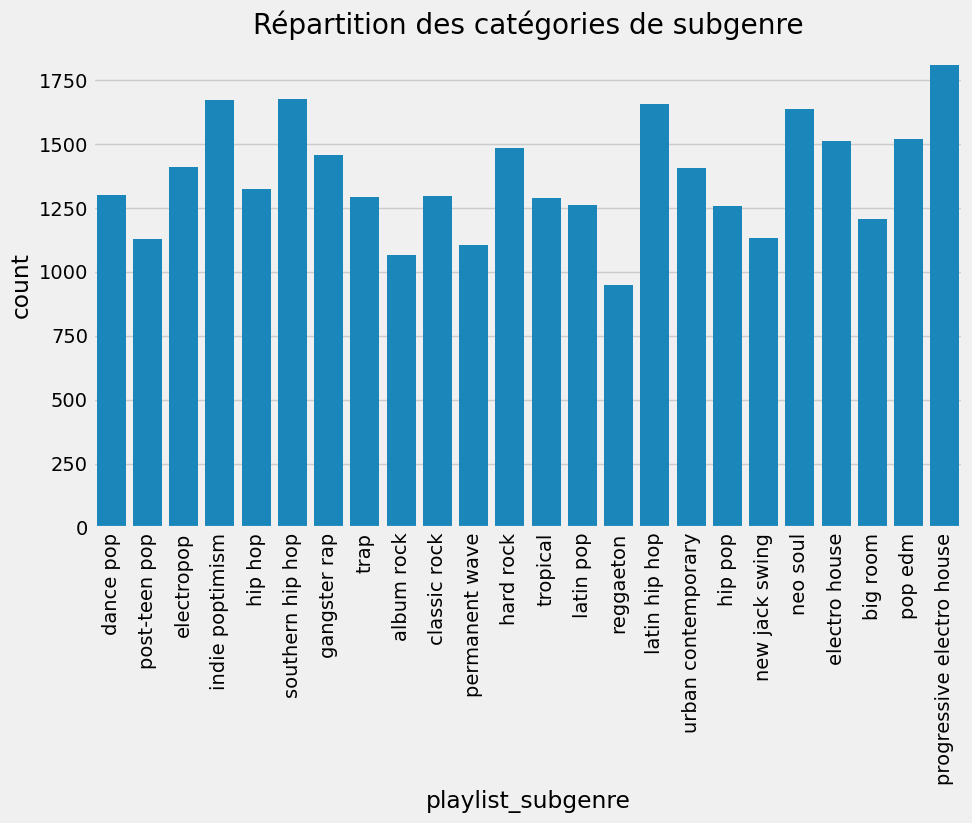

In [127]:
plt.figure(figsize=(10, 6))
sns.countplot(x='playlist_subgenre', data=df)
plt.title('Répartition des catégories de subgenre')
plt.xticks(rotation=90)
plt.show()

In [128]:
print(df['playlist_subgenre'].value_counts(normalize=True))

playlist_subgenre
progressive electro house    0.055097
southern hip hop             0.051016
indie poptimism              0.050924
latin hip hop                0.050437
neo soul                     0.049858
pop edm                      0.046204
electro house                0.046021
hard rock                    0.045229
gangster rap                 0.044407
electropop                   0.042884
urban contemporary           0.042792
hip hop                      0.040264
dance pop                    0.039533
classic rock                 0.039472
trap                         0.039320
tropical                     0.039229
latin pop                    0.038437
hip pop                      0.038254
big room                     0.036731
new jack swing               0.034508
post-teen pop                0.034386
permanent wave               0.033655
album rock                   0.032437
reggaeton                    0.028904
Name: proportion, dtype: float64


Les subgenre ont tous des proportions différentes, on peut ainsi les encoder en créant une nouvelle colonne `playlist_subgenre_encoded` qui contient la proportion du subgenre dans le dataset, cette colonne permet d'identifier le subgenre, on peut donc supprimer la colonne subgenre. On a désormais des valeurs numériques.

In [129]:
df_encoded = df.copy()

subgenre_proportions = df_encoded['playlist_subgenre'].value_counts(normalize=True)
df_encoded['playlist_subgenre_encoded'] = df_encoded['playlist_subgenre'].map(subgenre_proportions)
df_encoded = df_encoded.drop(columns=['playlist_subgenre'])

df_encoded.head()

,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,playlist_subgenre_encoded
0,pop,0.643106,1.205761,6,1.417813,1,-0.410645,-0.334394,-0.386352,-0.808248,0.030257,0.046248,-0.404273,0.039533
1,pop,0.490988,0.644866,11,0.601505,1,-0.541183,-0.471831,-0.365805,1.082508,0.781581,-0.566250,-0.794628,0.039533
2,pop,0.138349,1.289062,1,1.138835,0,-0.311809,-0.439329,-0.386238,-0.518509,0.438119,0.100991,-0.624472,0.039533
3,pop,0.435672,1.283509,7,1.017875,1,-0.139001,-0.674736,-0.386306,0.090785,-1.004425,0.044027,-0.715802,0.039533
4,pop,-0.034513,0.744828,1,0.705335,1,-0.549885,-0.435150,-0.386352,-0.691575,0.918967,0.100103,-0.473496,0.039533


In [130]:
df_encoded.columns

Index(['playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'playlist_subgenre_encoded'],
      dtype='object')

In [131]:
df = df_encoded

En résumé, le tableau `df` ne contient plus de valeurs aberrantes grâce à la méthode du Z-score que nous avons utilisée, et les variables continues ont été standardisées. De plus, les valeurs manquantes ont été imputées et la variable catégorielle `playlist_subgenre` a été encodée.

L'étape de preprocessing est donc maintenant terminée.

## II.2. Réduction des features préparées

Nous utilisons d'abord la méthode `head()` pour obtenir un aperçu des premières lignes de notre DataFrame et explorer les principales caractéristiques de ses features. 

In [132]:
df.head()

,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,playlist_subgenre_encoded
0,pop,0.643106,1.205761,6,1.417813,1,-0.410645,-0.334394,-0.386352,-0.808248,0.030257,0.046248,-0.404273,0.039533
1,pop,0.490988,0.644866,11,0.601505,1,-0.541183,-0.471831,-0.365805,1.082508,0.781581,-0.566250,-0.794628,0.039533
2,pop,0.138349,1.289062,1,1.138835,0,-0.311809,-0.439329,-0.386238,-0.518509,0.438119,0.100991,-0.624472,0.039533
3,pop,0.435672,1.283509,7,1.017875,1,-0.139001,-0.674736,-0.386306,0.090785,-1.004425,0.044027,-0.715802,0.039533
4,pop,-0.034513,0.744828,1,0.705335,1,-0.549885,-0.435150,-0.386352,-0.691575,0.918967,0.100103,-0.473496,0.039533


### II.2.a. Analyse multivariée

In [133]:
continuous_vars=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
categorical_vars=['key', 'mode',  'playlist_genre', 'playlist_subgenre_encoded']

Ensuite, nous convertissons les variables catégorielles de la liste `categorical_vars` au type de données approprié (`category`) pour optimiser l'utilisation de la mémoire et les préparer à l'analyse :  

Cette étape permet de simplifier la gestion des données catégorielles dans le DataFrame.

In [134]:
df[categorical_vars] = df[categorical_vars].astype('category')

Commençons tout d'abord par observer la matrice des corrélations pour nos variables continues. Cela pourrait permettre d'éliminer des variables fortement corrélées.

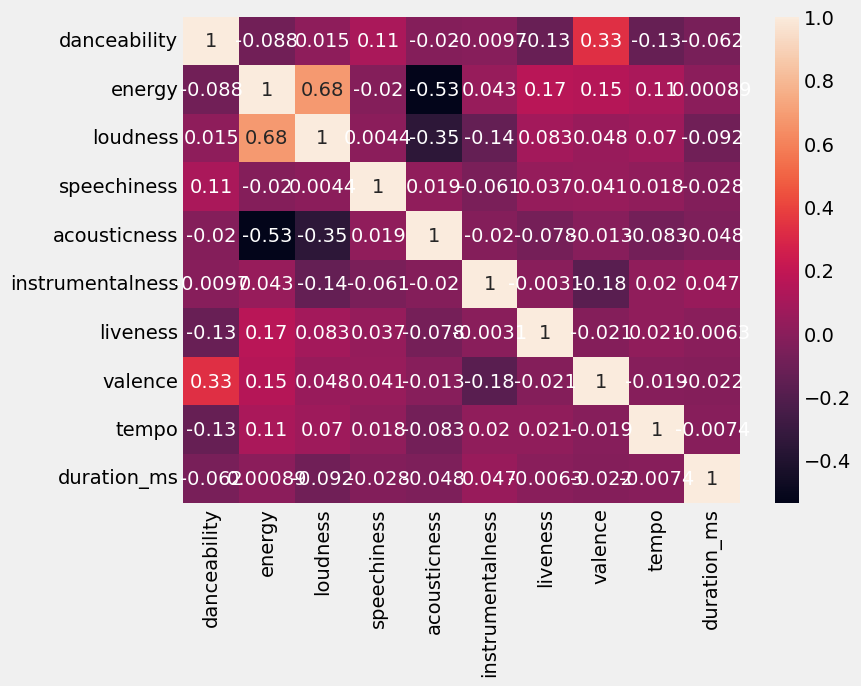

In [135]:
plt.figure(figsize=(8,6))
sns.heatmap(df[continuous_vars].corr(),annot=True);

La corrélation la plus forte que nous observons est entre `energy` et `acousticness`. Celle-ci est de -0.53, ce chiffre est assez élevé et pourrait nous permettre de laisser de côté l'une de ces deux colonnes, néanmoins nous choisissons de la garder. En effet, normalement on considère qu'un colonne peut être supprimer si la corrélation est supérieure  à 0.8. *(cf. Dormann et al. (2013))*

Pour mieux visualiser les écarts entre les différentes variables dans la prédiction du genre, nous allons tracer des boxplots.

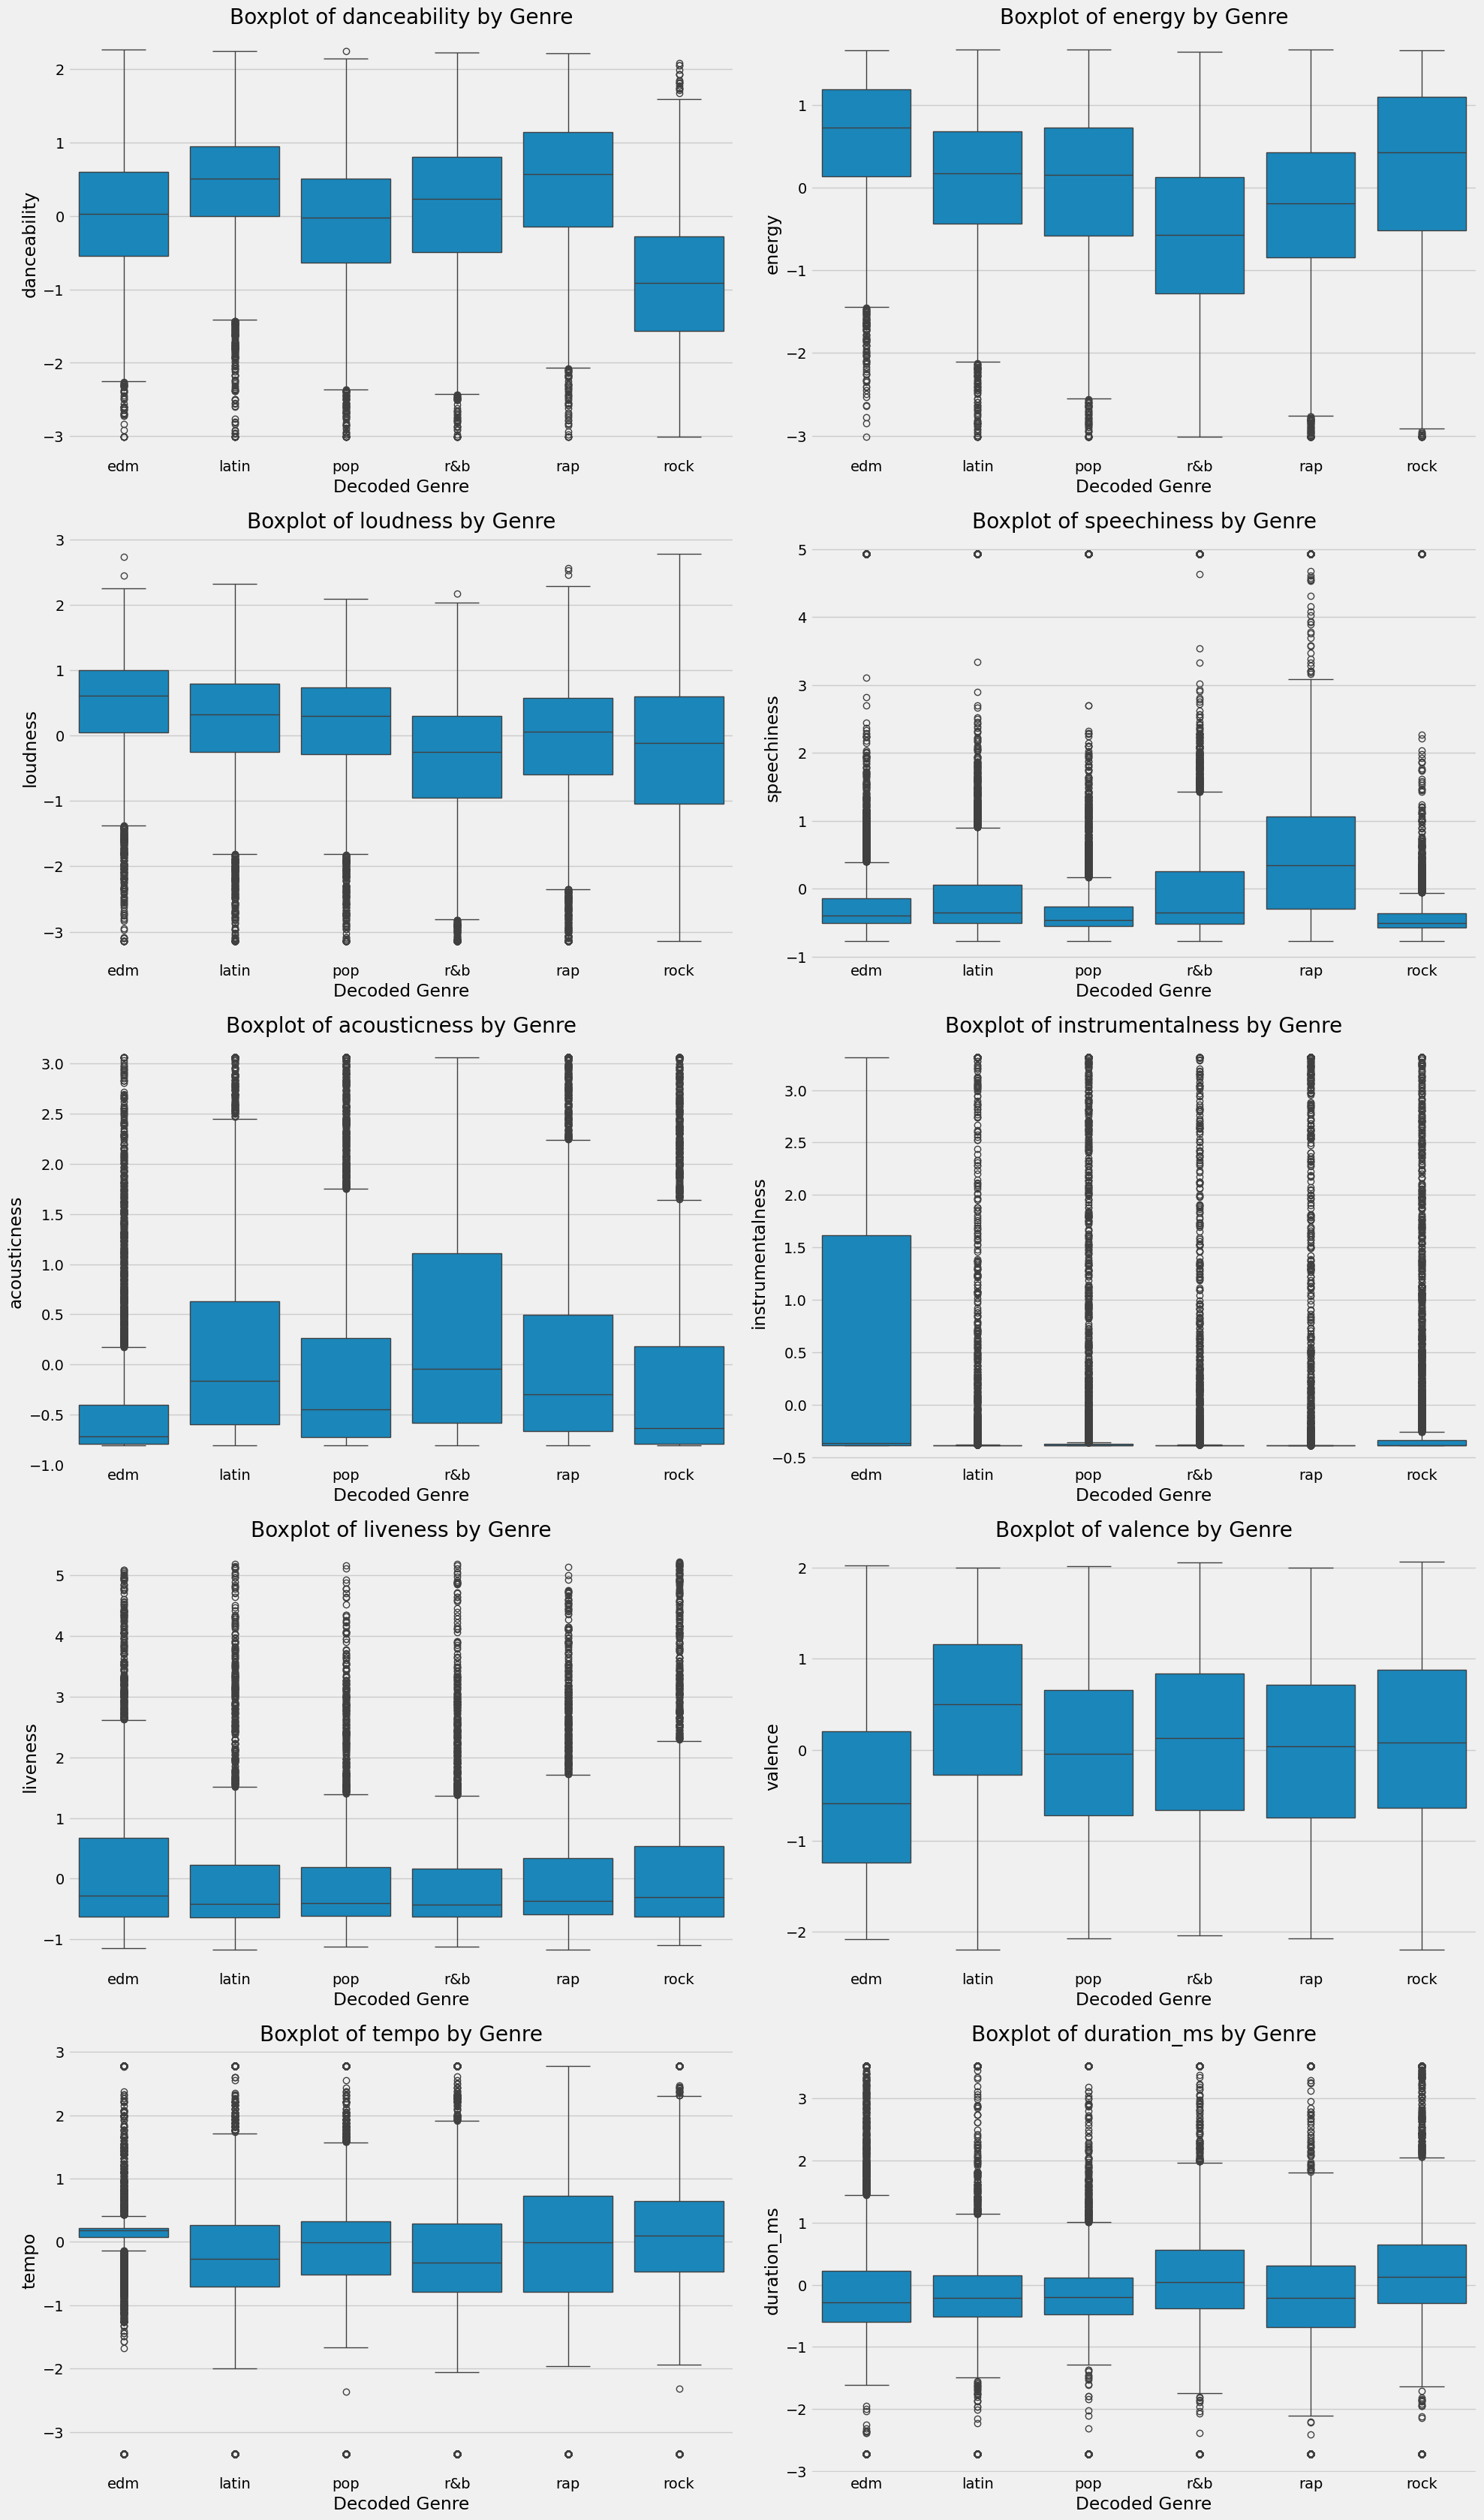

In [136]:
plt.figure(figsize=(20, 40))

for i, var in enumerate(continuous_vars):
    plt.subplot(6, 2, i+1)
    sns.boxplot(x='playlist_genre', y=var, data=df)
    plt.title(f'Boxplot of {var} by Genre')
    plt.xlabel('Decoded Genre')
    plt.ylabel(var)

plt.tight_layout()
plt.show()


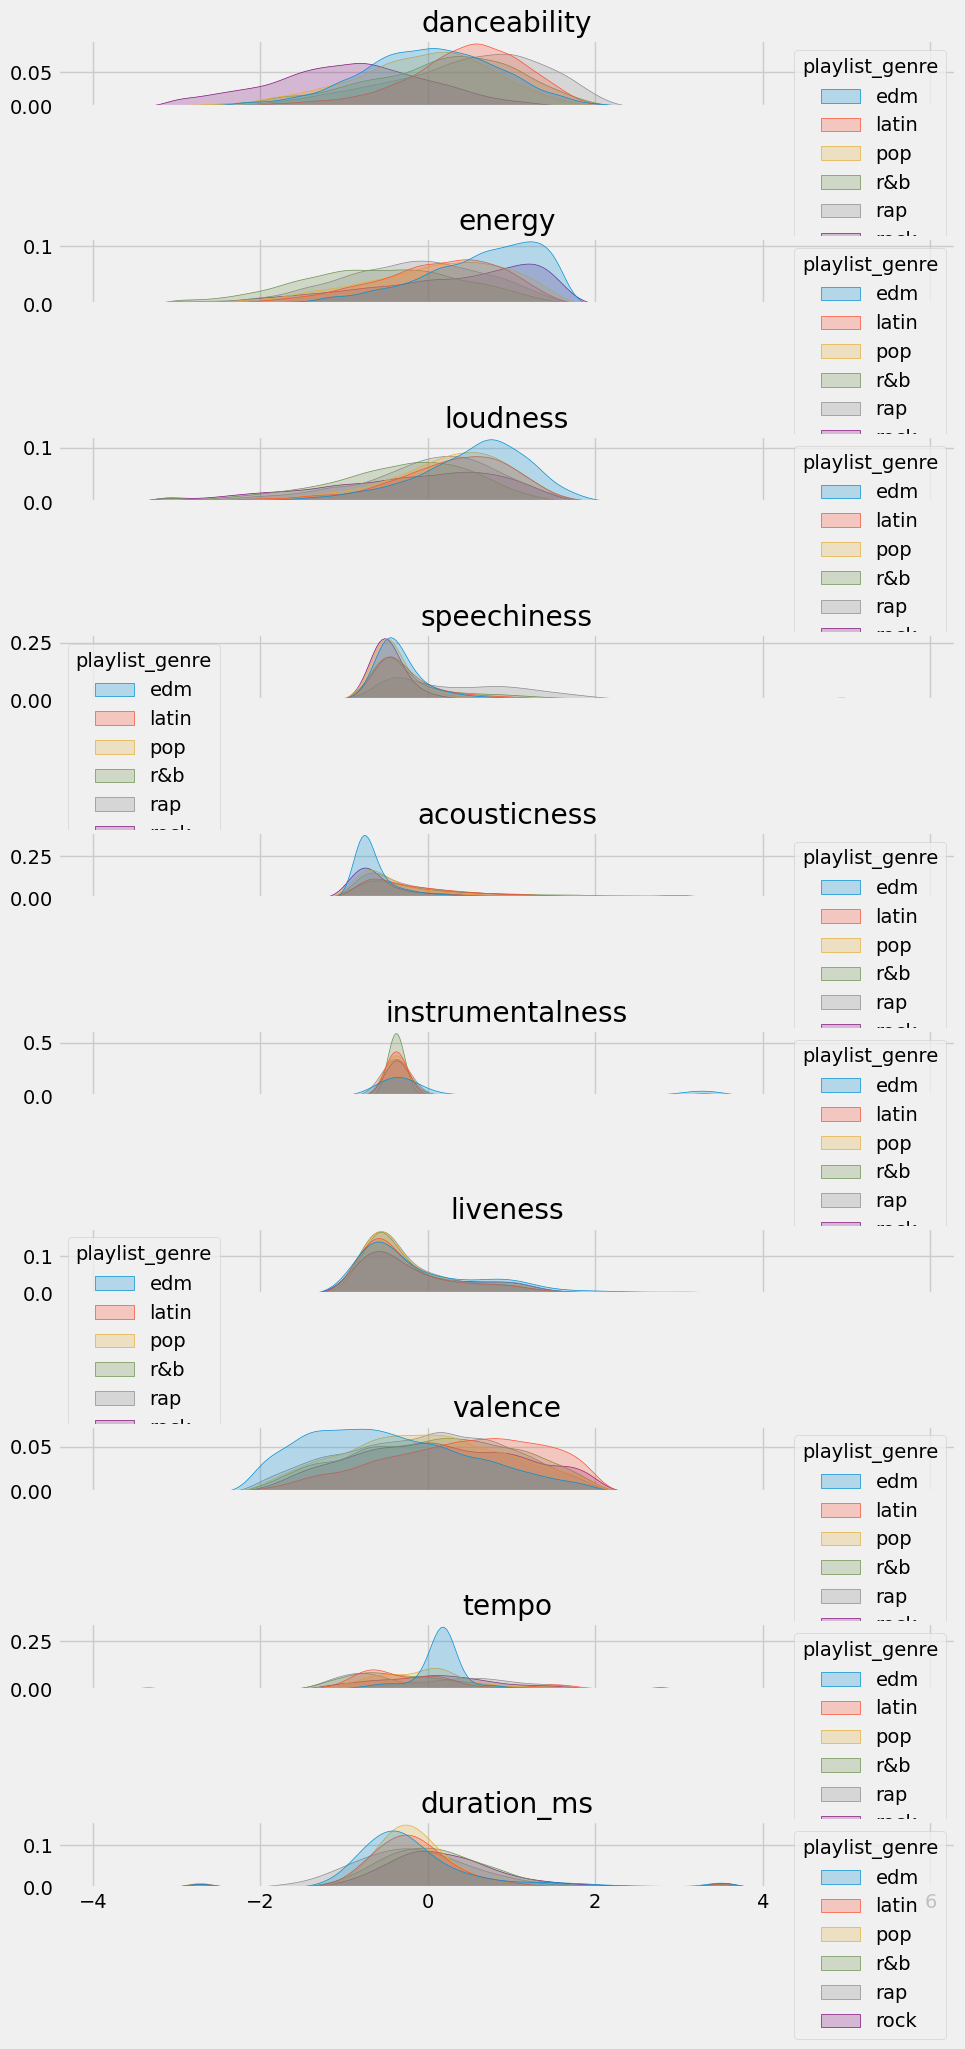

In [137]:
fig, axes = plt.subplots(len(continuous_vars),sharex=True, figsize=(10,20))

for ax, var in zip(axes, continuous_vars):
  sns.kdeplot(data=df, x=var, hue="playlist_genre", fill="playlist_genre",ax=ax);
  ax.set_title(var)
  ax.set_xlabel("")
  ax.set_ylabel("")

plt.tight_layout()

- Le niveau de `danceability` est assez élevé pour les genres EDM et Latin. A l'inverse, le genre Rock semble avoir une médiane plus basse, indiquant que les chansons rock sont globalement moins dansantes. Les genres Pop, Rap et R&B montrent une distribution similaire avec une médiane modérée. Cela peut être dû au fait que ces dernières musiques sont des genres récents et que la frontière entre les genres est plus fine aujourd'hui.

- EDM a l'`energy` la plus élevée, avec une médiane haute une distribution très concentrée. C'est en effet un genre de musique très rythmé. Les musiques Rock, Rap et Latin montrent également une bonne énergie, tandis que les musiques Pop et R&B ont des niveaux plus modérés. En effet, ce type de chansons est souvent plus calme.

- Les musiques Rap présentent une valeur élevée de `speechiness`, ce qui était prévisible étant donné que ce genre repose beaucoup sur les paroles.

- Les genres EDM et Rock sont les plus bruyants, ce qui est cohérent. La plage de valeurs est plus large pour les genres Pop et Rap. Cela démontre que ces genres peuvent être parfois calmes et parfois plus énergiques, observation que l'on retrouvait sur la variable `energy`

- Les chansons de R&B et Latin sont souvent plus acoustiques. Alors que celles d'EDM sont très électroniques (valeur proche de 0 pour `acousticness`) ce qui fait sens.

- La `liveness` est proche de 0 ce qui montre que les musiques sont quasiment toutes des versions studio.

En conclusion les genres musicaux semblent montrer des tendances claires dans leur répartition, par exemple:

- EDM est énergique, rapide et souvent instrumental.
- Rap se distingue par une `speechiness` élevée.
- Latin est dansant, joyeux, et acoustique.

Ces tendances permettent d'identifier des différences claires entre les différents genres de musique ce qui nous permettra de mener à bien la classification lors de la phase de modélisation.


### II.2.b. Vérification du poids des variables

Pour vérifier si certaines variables pourraient être supprimées, nous allons réaliser une Analyse en Composantes Principales (ACP) et utiliser un modèle de Random Forest afin d'analyser l'importance de chaque variable.

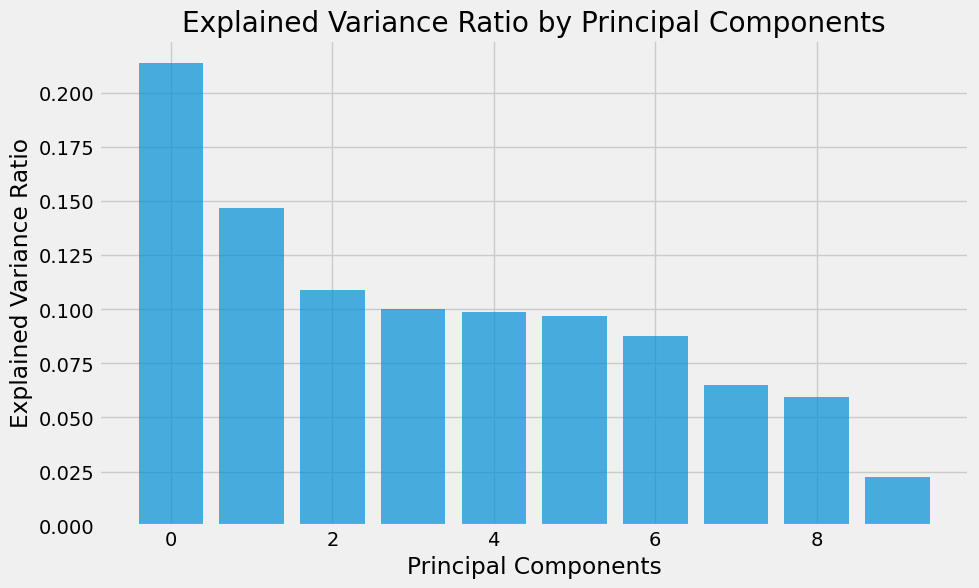

In [138]:
df_pca=df[continuous_vars]
# Réalisation de l'ACP
pca = PCA()
pca.fit(df_pca)
# Obtention de la part de variance expliquée par composante
explained_variance = pca.explained_variance_ratio_
# Affichage de la part de variance expliquée par composante
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.7, align='center')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

L'ACP ne nous permet pas de réduire notre dataframe à quelques composantes principales, en effet, les deux premières composantes n'incluent qu'une faible part d'explication de la variance. Cela se reflète également dans la répartition de l'importance de chaque variable dans les composantes principales, comme montré ci-dessous :

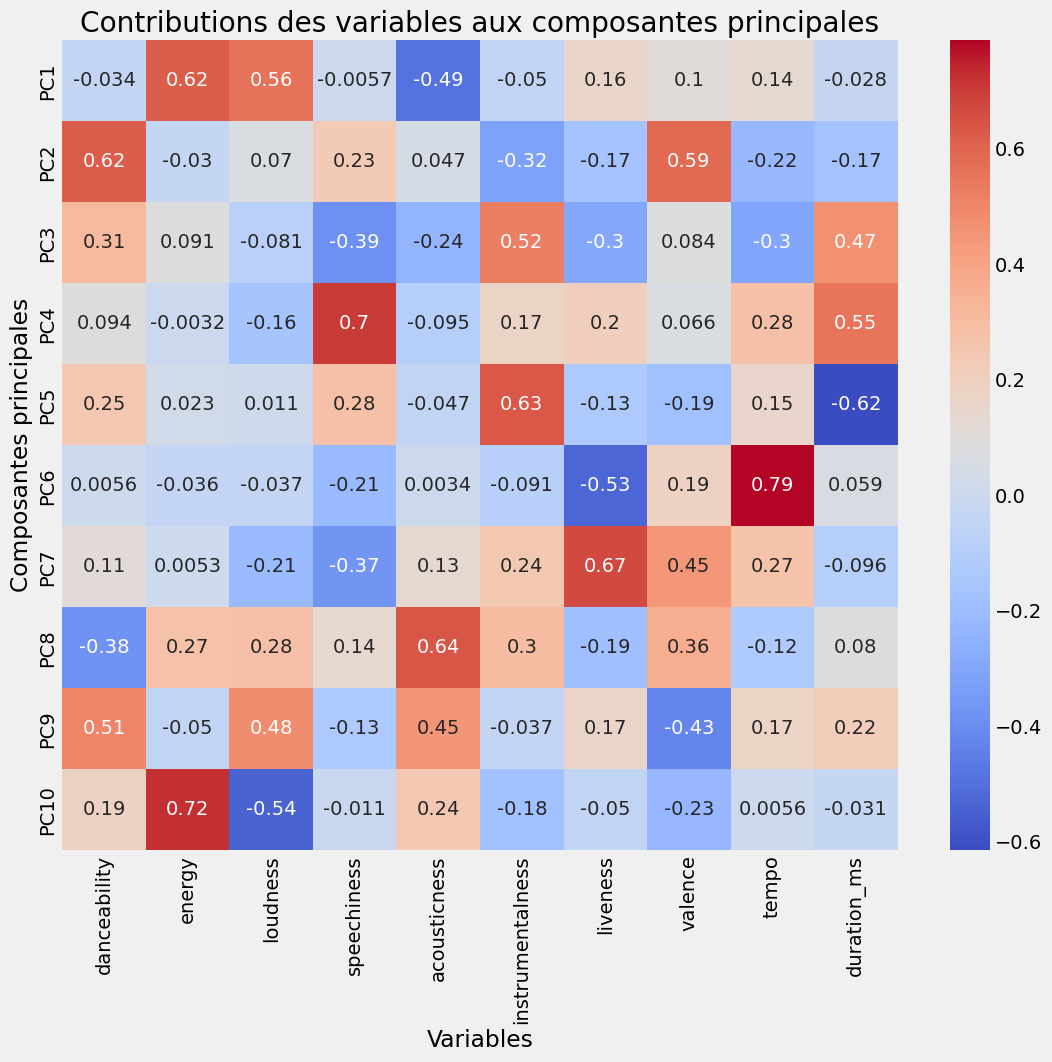

In [139]:
components = pd.DataFrame(pca.components_, columns=df_pca.columns)
plt.figure(figsize=(12, 10))
sns.heatmap(components, annot=True, cmap='coolwarm', xticklabels=df_pca.columns, yticklabels=[f'PC{i+1}' for i in range(len(components))])
plt.title("Contributions des variables aux composantes principales")
plt.xlabel("Variables")
plt.ylabel("Composantes principales")
plt.show()

Afin de vérifier si des composantes qualitatives pourraient être supprimées, nous réalisons un Random Forest pour évaluer le poids de chaque variable : 

In [140]:
# Séparation des caractéristiques (features) et de la cible (target)
X = df.drop('playlist_genre', axis=1)
y = df['playlist_genre']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Importance des variables
importances = model.feature_importances_
feature_names = X.columns

# Création d'un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage des importances
print(importance_df)

                      Feature  Importance
12  playlist_subgenre_encoded    0.435094
0                danceability    0.070984
5                 speechiness    0.070107
10                      tempo    0.063387
1                      energy    0.058994
6                acousticness    0.051567
9                     valence    0.049515
3                    loudness    0.048475
11                duration_ms    0.047921
7            instrumentalness    0.044429
8                    liveness    0.031958
2                         key    0.020795
4                        mode    0.006775


`playlist_subgenre_encoded` occupe une importance forte, nous pourrions n'utiliser que cette variable pour notre étude. Cependant, cette variable contient en réalité l'information du genre, nous allons donc la supprimer du dataframe.

In [141]:
df = df.drop(['playlist_subgenre_encoded'],axis=1)

In [142]:
# Séparation des caractéristiques (features) et de la cible (target)
X = df.drop('playlist_genre', axis=1)
y = df['playlist_genre']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Importance des variables
importances = model.feature_importances_
feature_names = X.columns

# Création d'un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage des importances
print(importance_df)

             Feature  Importance
10             tempo    0.115546
0       danceability    0.114421
5        speechiness    0.112464
1             energy    0.098311
9            valence    0.092151
6       acousticness    0.090516
11       duration_ms    0.088199
3           loudness    0.086559
7   instrumentalness    0.073279
8           liveness    0.069515
2                key    0.045209
4               mode    0.013831


Nous pourrions supprimer certaines variables comme `mode`, `key` et `liveness` mais nous allons pour l'instant les garder dans notre modèle.

## II.3. Modélisation

Maintenant que les données sont prêtes à être exploitées, nous pouvons nous lancer dans la prédiction du genre par machine learning.

### II.3.a. Random Forest

Tout d'abord, nous séparons la variable cible (le genre) des autres variables. Ensuite, nous divisons ces ensembles en deux parties : une pour entraîner le modèle et une autre pour le tester. Étant donné que notre jeu de données est organisé par genre, nous spécifions qu'il doit être divisé aléatoirement en utilisant l'argument `shuffle=True`.

In [143]:
features = df.copy()

genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.2, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

Training Features Shape: (26266, 12)
Training Genres Shape: (26266,)
Testing Features Shape: (6567, 12)
Testing Genres Shape: (6567,)


Pour optimiser les performances de nos modèles, nous effectuons un ajustement des hyperparamètres. Cette étape vise à trouver la meilleure combinaison de paramètres permettant de maximiser la précision du modèle sur l'ensemble de test.  

Il existe en effet un très grand nombre d'hyperparamètres à ajuster. Pour simplifier les choses, nous nous concentrons sur les trois hyperparamètres clés suivants :  

1. **Nombre d'arbres** (*n_estimators*) : Contrôle le nombre d'arbres dans l'ensemble.  
2. **Profondeur maximale des arbres** (*max_depth*) : Détermine la profondeur maximale de chaque arbre.  
3. **Nombre minimum d'échantillons par nœud** (*min_child_samples* ou *min_samples_split*) : Spécifie le nombre minimum d'échantillons requis dans un nœud pour permettre une division supplémentaire.  

Nous n'avons pas spécifié de poids pour chaque genre, car le jeu de données est relativement équilibré. Cependant, pour améliorer encore le modèle, nous pourrions attribuer des poids à chaque genre afin de simuler un jeu de données parfaitement équilibré.  

In [144]:
n_estimators = [1000, 2000, 4000]
max_depth = [20,None]
min_samples_split = [2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
              }

print(random_grid)

{'n_estimators': [1000, 2000, 4000], 'max_depth': [20, None], 'min_samples_split': [2, 4]}


Nous effectuons une recherche aléatoire en utilisant ces hyperparamètres et classons les différentes combinaisons en fonction de leur précision un GridSearch pourrait prendre trop de temps de calcul.

In [145]:
# Création du modèle
rf = RandomForestClassifier(random_state = 0, max_features = 'sqrt', bootstrap = True)

# Recherche des meilleurs hyperparamètres
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 12, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# Entrainement du modèle
rf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(rf_random.cv_results_["params"]),pd.DataFrame(rf_random.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(rf_random.best_params_)
print(pd_res.head)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  54.4s
[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  55.2s
[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  56.9s
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.8min
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.8min
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.8min
[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  52.5s
[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  52.0s


/opt/conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  52.6s
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.6min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.6min
[CV] END max_depth=20, min_samples_split=4, n_estimators=2000; total time= 1.7min
[CV] END max_depth=20, min_samples_split=4, n_estimators=2000; total time= 1.8min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.6min
[CV] END max_depth=20, min_samples_split=4, n_estimators=2000; total time= 1.7min
[CV] END max_depth=None, min_samples_split=2, n_estimators=1000; total time=  55.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=1000; total time=  54.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=1000; total time=  54.9s
[CV] END max_depth=20, min_samples_split=4, n_estimators=4000; total time= 3.6min
[CV] END max_depth=20, min_samples_split=4, n_estimators=4000; total time= 3.8min
[CV] END m

Nous considérons donc que le modèle est le plus efficace avec un nombre d'arbres fixé à 4000 et max_depth à 20.

A présent, nous allons faire tourner le modèle.

In [146]:
rf = RandomForestClassifier(n_estimators=4000, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, criterion='gini' ,random_state=0)

rf.fit(train_features, train_genres)

predictions = rf.predict(test_features)


errors = zero_one_loss(test_genres, predictions, normalize=True)
print('zero_one_loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('accuracy_score on test dataset :', accuracy_test)

print(classification_report(predictions, test_genres))

zero_one_loss error normalized: 0.44571341556266175
accuracy_score on test dataset : 0.5542865844373382
              precision    recall  f1-score   support

         edm       0.68      0.67      0.67      1271
       latin       0.40      0.52      0.45       788
         pop       0.34      0.37      0.36      1023
         r&b       0.47      0.48      0.48      1043
         rap       0.65      0.57      0.61      1306
        rock       0.77      0.66      0.71      1136

    accuracy                           0.55      6567
   macro avg       0.55      0.55      0.55      6567
weighted avg       0.57      0.55      0.56      6567



Nous obtenons une *accuracy* de 55,4% ce qui est satisfaisant. Toutefois, nous allons plotter la matrice de confusion pour visualiser les différentes erreurs.

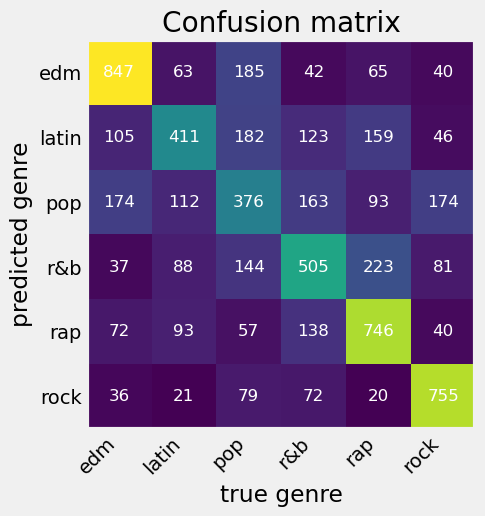

In [147]:
mat = confusion_matrix(test_genres, predictions)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Nous parvenons à prédire efficacement les genres rap, rock et edm, tandis que les genres pop, latin et r&b sont prédits avec moins de précision, comme nous l'avions anticipé à partir de la visualisation et de l'analyse des données.

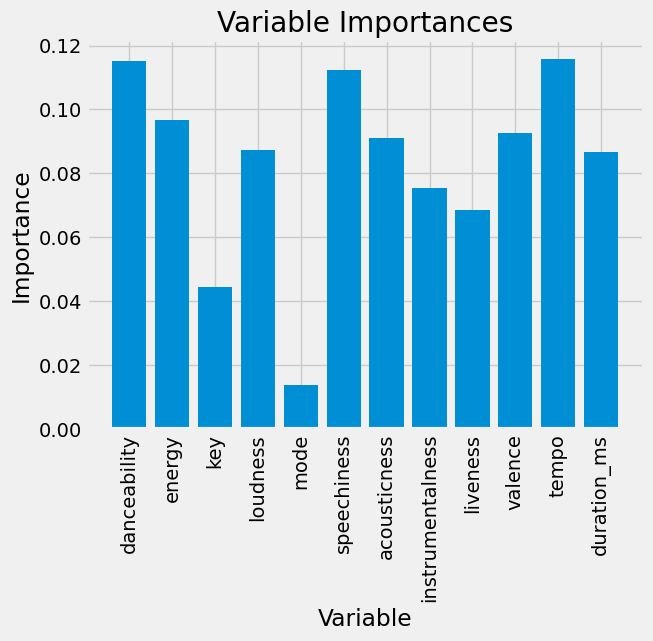

In [148]:
# Importance des variables
plt.style.use('fivethirtyeight')

importances = list(rf.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

Enfin, nous traçons l'importance de chaque caractéristique et constatons que les variables `key` et `mode` ne contribuent que peu à la prédiction. Cela était attendu, car ces variables présentent une faible variabilité et ne sont pas fortement corrélées avec les genres musicaux. Cela correspond à nos observations lors du feature-engineering, où nous avions déjà noté leur faible importance dans les composantes principales par rapport aux autres variables.

Ainsi, notre modèle Random Forest atteint une précision de 55,4 %, ce qui est satisfaisant. Cependant, il montre de mauvaises performances pour identifier les genres latin, pop et R&B, qui sont très répandus dans le monde musical, tandis qu'il excelle dans l'identification du genre edm, rap et rock. Cela semble logique car la frontière en latin, pop et r&b est parfois ténue et des morceaux peuvent être des hybrides entre deux genres. Cela est beaucoup moins le cas pour edm, rap et rock. 

### II.3.b XGBoost

Afin de réaliser une modélisation avec XGBoost, il est nécessaire d'encoder nos variables, nous pourrions utiliser un module déjà implementé. Néanmoins, afin de conserver notre encodage et au vu de notre faible nombre de valeurs prises par notre variable cible, nous codons l'encodage.

In [149]:
features = df.copy()

def genre_to_num(genre):
    if genre == 'edm':
        return 0
    if genre == 'latin':
        return 1
    if genre == 'pop':
        return 2
    if genre == 'r&b':
        return 3
    if genre == 'rap':
        return 4
    if genre == 'rock':
        return 5

features['playlist_genre'] = features['playlist_genre'].apply(genre_to_num)

In [150]:
# Isolement de la variable cible
genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# train/test split
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

Training Features Shape: (24624, 12)
Training Genres Shape: (24624,)
Testing Features Shape: (8209, 12)
Testing Genres Shape: (8209,)


Nous utilisons la même méthode que pour Random Forest afin de déterminer nos hyperparamètres en nous concentrant sur `max_depth` et `n_estimators`:

In [151]:
random_grid = {
    "gamma" : [0],
    "learning_rate" : [0.1],
    "max_depth" : [20, None],
    "n_estimators" : [100, 200, 300, 400, 500], 
    "subsample" : [0.8]}

pprint(random_grid)

{'gamma': [0],
 'learning_rate': [0.1],
 'max_depth': [20, None],
 'n_estimators': [100, 200, 300, 400, 500],
 'subsample': [0.8]}


In [152]:
# Création du modèle
clf = XGBClassifier(objective='multi:softprob', random_state=42)

# Recherche des meilleurs hyperparamètres
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=10, cv=3, verbose=2, random_state=0, n_jobs=-1)

# Ajustement du modèle
clf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(clf_random.cv_results_["params"]), pd.DataFrame(clf_random.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=100, subsample=0.8; total time=  22.3s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=100, subsample=0.8; total time=  22.3s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=100, subsample=0.8; total time=  24.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=200, subsample=0.8; total time=  32.0s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=200, subsample=0.8; total time=  32.6s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=200, subsample=0.8; total time=  32.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=300, subsample=0.8; total time=  36.9s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=300, subsample=0.8; total time=  39.9s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=300, subsample=0.8; total time=  39.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=400, subs

In [153]:
param_grid = {
    "learning_rate" : [0.1], #d0.3
    "max_depth"        : [20], #d6
    "n_estimators" : [100, 200, 300], #d100
    "subsample" : [0.8], #d1
}

pprint(param_grid)

{'learning_rate': [0.1],
 'max_depth': [20],
 'n_estimators': [100, 200, 300],
 'subsample': [0.8]}


In [154]:
clf = XGBClassifier(objective= 'multi:softprob', random_state = 0)

grid = GridSearchCV(clf, param_grid = param_grid, n_jobs=-1, scoring="accuracy", cv=3) #scoring="neg_log_loss"
grid.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)

   learning_rate  max_depth  n_estimators  subsample  Accuracy
0            0.1         20           100        0.8  0.533951
2            0.1         20           300        0.8  0.533748
1            0.1         20           200        0.8  0.533707


Nous pouvons maintenant entraîner le modèle avec 300 arbres, un learning rate de 0.1, une max_depth de 20 et subsample de 0.8

In [155]:
model_xgb = XGBClassifier(objective='multi:softprob', colsample_bylevel=1, colsample_bytree=1, 
                          gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=20, min_child_weight=1, 
                          n_estimators=300, subsample=0.8, random_state = 42)

model_xgb.fit(train_features, train_genres)

predict_test = model_xgb.predict(test_features)
 

accuracy_test = accuracy_score(test_genres, predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)
print(classification_report(predict_test, test_genres))


accuracy_score on test dataset :  0.549884273358509
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1573
           1       0.41      0.48      0.45      1099
           2       0.33      0.36      0.34      1246
           3       0.48      0.48      0.48      1337
           4       0.64      0.58      0.61      1561
           5       0.75      0.67      0.71      1393

    accuracy                           0.55      8209
   macro avg       0.55      0.54      0.54      8209
weighted avg       0.56      0.55      0.55      8209



Nous obtenons une *accuracy* de 54,9% ce qui est très similaire au modèle précédent. Cependant, le temps de calcul est netemment plus rapide ce qui est intéressant du point de vue du coût computationnel. De plus, le modèle est beaucoup plus léger (quelques mégas contre quelqués gigas pour random forest)


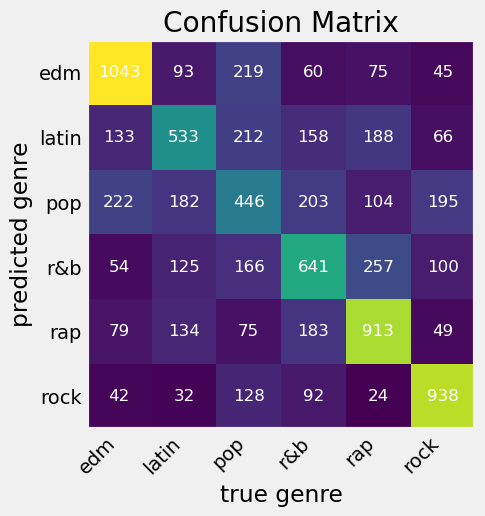

In [156]:
# Matrice de confusion
mat = confusion_matrix(test_genres, predict_test)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Comme avec Random Forest, nous prédisons bien edm, rap et rock mais moins bien latin, pop et r&b.

### II.3.c. Catboost

Nous appliquons la même méthode que précédemment pour préparer nos données et ajuster nos hyperparamètres

In [157]:
features = df.copy()

# Isolement de la variable cible
genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# train/test split
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)


Training Features Shape: (24624, 12)
Training Genres Shape: (24624,)
Testing Features Shape: (8209, 12)
Testing Genres Shape: (8209,)


In [158]:
# Création du modèle
model = CatBoostClassifier(cat_features=[], iterations=1000, learning_rate=0.1, depth=6, verbose=0)

# Optimisation des hyperparamètres avec RandomizedSearchCV
param_dist = {
    'iterations': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [5, 6, 7, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=12, cv=3, verbose=2, random_state=0, n_jobs=-1)
random_search.fit(train_features, train_genres)

# Affichage des résultats de la recherche
print("Best parameters found: ", random_search.best_params_)

# Résultats détaillés
pd_res = pd.concat([pd.DataFrame(random_search.cv_results_["params"]),
                    pd.DataFrame(random_search.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res.head())

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[CV] END border_count=64, depth=5, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=  17.1s
[CV] END border_count=64, depth=5, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=  17.1s
[CV] END border_count=64, depth=5, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=  17.1s
[CV] END border_count=32, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=  39.0s
[CV] END border_count=32, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=  39.1s
[CV] END border_count=32, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=  36.8s
[CV] END border_count=64, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.2; total time=  41.1s
[CV] END border_count=64, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.2; total time=  41.5s
[CV] END border_count=64, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.2; total time=  41.2s
[CV] END border_count=32, depth=5, iterations=500, l2_leaf

/opt/conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END border_count=128, depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.1; total time= 1.6min
[CV] END border_count=128, depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.1; total time= 1.6min
[CV] END border_count=128, depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.1; total time= 1.6min
[CV] END border_count=32, depth=7, iterations=2000, l2_leaf_reg=3, learning_rate=0.1; total time= 2.1min
[CV] END border_count=32, depth=7, iterations=2000, l2_leaf_reg=3, learning_rate=0.1; total time= 2.1min
[CV] END border_count=64, depth=5, iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=  34.1s
[CV] END border_count=32, depth=7, iterations=2000, l2_leaf_reg=3, learning_rate=0.1; total time= 2.0min
[CV] END border_count=32, depth=7, iterations=2000, l2_leaf_reg=5, learning_rate=0.2; total time= 2.0min
[CV] END border_count=32, depth=7, iterations=2000, l2_leaf_reg=5, learning_rate=0.2; total time= 2.1min
[CV] END border_count=64, depth=5, iterations=1000,

Les paramètres choisis sont:
- Learning rate `learning_rate` : 0.05
- L2 leaf regularization `l2_leaf_reg` : 1
- Number of trees `iterations` : 1000
- Depth `depth` : 5
- Border count `border_count` : 64

In [159]:
model = CatBoostClassifier(learning_rate=0.05,l2_leaf_reg=1,n_estimators=1000,depth=5,border_count=64, 
                           cat_features=[], verbose=0)

# entraînement
model.fit(train_features, train_genres)

# Predictions
predictions = model.predict(test_features)

# Zero-One Loss Error
errors = zero_one_loss(test_genres, predictions, normalize=True)
print('Zero-One Loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('Accuracy score on test dataset:', accuracy_test)

# Classification Report
print(classification_report(test_genres, predictions))

Zero-One Loss error normalized: 0.4435375807041052
Accuracy score on test dataset: 0.5564624192958948
              precision    recall  f1-score   support

         edm       0.68      0.69      0.69      1535
       latin       0.48      0.38      0.43      1290
         pop       0.38      0.36      0.37      1352
         r&b       0.49      0.47      0.48      1343
         rap       0.59      0.67      0.63      1433
        rock       0.66      0.74      0.70      1256

    accuracy                           0.56      8209
   macro avg       0.55      0.55      0.55      8209
weighted avg       0.55      0.56      0.55      8209



Nous obtenons une *accuracy* de 55,6% ce qui est proche des résultats précédents.

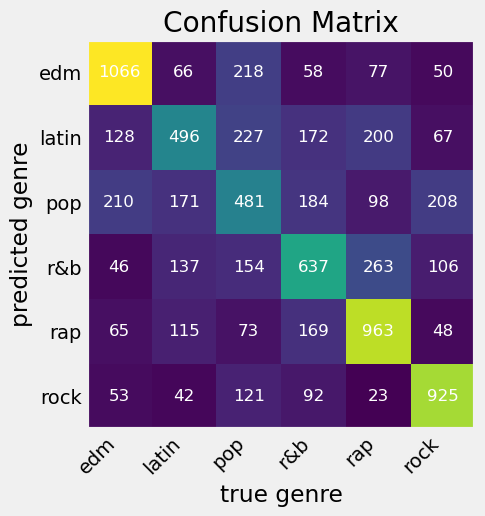

In [160]:
# Matrice de confusion

mat = confusion_matrix(test_genres, predictions)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Encore une fois, les genres les mieux prédits sont edm, rap et rock et les moins bien prédits sont latin pop et r&b.

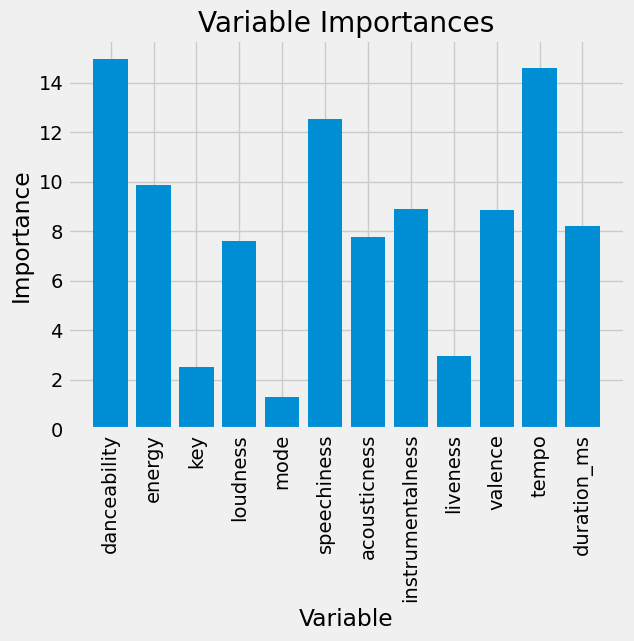

In [161]:
# Importance des features
plt.style.use('fivethirtyeight')

importances = list(model.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

Nous observons un changement par rapport aux graphiques des deux modèles précédents. En effet, il semble que le modèle CatBoost s’appuie moins sur la variable `liveness` que les autres. Cependant, nous constatons toujours des similitudes, comme le fait que les variables `key` et `mode` n'ont que peu d’impact sur la prédiction du genre musical.  

De plus, notre modèle CatBoost nous permet de prédire un genre musical avec une précision de 56 %, ce qui est plutôt satisfaisant. Néanmoins, il garde les mêmes erreurs de prédiction sur latin, r&b et pop que les deux autres modèles.

# Conclusion

Nous avons été en mesure de prédire le genre d'une musique à l'aide de quelques caractéristiques audio avec une précision de 56%. Ce résultat est encourageant au vu de la taille réduite de notre dataset d'entraînement.

Nous avons testé trois modèles : Random Forest, XGBoost et CatBoost, qui ont tous donné des résultats similaires et globalement satisfaisants. Néanmoins, le coût temporel et spatial diffère fortement selon ces modèles. En effet, random forest occupe un espace et demande des calculs beaucoup plus importants que les deux autres. Ces approches seraient donc celles à prioriser.

Une piste d'amélioration serait une meilleure prédiction des genres pop et R&B. Cependant, le principal défi de notre projet semble résider dans le fait que l'attribution d'un genre musical est intrinsèquement subjective, ce qui se reflète dans les caractéristiques communes des genres comme le pop et le R&B.